In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from datetime import datetime

In [127]:
df = pd.read_csv('/content/drive/MyDrive/datasets/marketing_campaign_data.csv')
df.head()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,0,5524,1957,S1,Lajang,58138000.0,0,0,04-09-2012,58,...,7,0,0,0,0,0,0,3,11,1
1,1,2174,1954,S1,Lajang,46344000.0,1,1,08-03-2014,38,...,5,0,0,0,0,0,0,3,11,0
2,2,4141,1965,S1,Bertunangan,71613000.0,0,0,21-08-2013,26,...,4,0,0,0,0,0,0,3,11,0
3,3,6182,1984,S1,Bertunangan,26646000.0,1,0,10-02-2014,26,...,6,0,0,0,0,0,0,3,11,0
4,4,5324,1981,S3,Menikah,58293000.0,1,0,19-01-2014,94,...,5,0,0,0,0,0,0,3,11,0


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           2240 non-null   int64  
 1   ID                   2240 non-null   int64  
 2   Year_Birth           2240 non-null   int64  
 3   Education            2240 non-null   object 
 4   Marital_Status       2240 non-null   object 
 5   Income               2216 non-null   float64
 6   Kidhome              2240 non-null   int64  
 7   Teenhome             2240 non-null   int64  
 8   Dt_Customer          2240 non-null   object 
 9   Recency              2240 non-null   int64  
 10  MntCoke              2240 non-null   int64  
 11  MntFruits            2240 non-null   int64  
 12  MntMeatProducts      2240 non-null   int64  
 13  MntFishProducts      2240 non-null   int64  
 14  MntSweetProducts     2240 non-null   int64  
 15  MntGoldProds         2240 non-null   i

# Feature Engineering

Kolom baru:

1. Total Response
2. Age
3. Membership Lenght
4. Total Child
5. Total Purchase
6. Total amount spent
7. Education Encoded
8. One hot encoding for Marital status

Kolom dropped:
'Year_Birth', 'ID', 'Unnamed: 0', 'Dt_Customer'

In [129]:
#Get Total Campaign per ID
df['TotalResponses'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum(axis=1)
# Get the current year
current_year = datetime.now().year
# Create a new 'Age' column by subtracting 'Year_Birth' from the current year
df['Age'] = current_year - df['Year_Birth']
# Convert 'Dt_Customer' to datetime format
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
# Get the current date
current_date = datetime.now()
# Calculate the membership length in years
df['MembershipLength'] = (current_date - df['Dt_Customer']).dt.days // 365
# Calculate the total child
df['TotalChild'] = df[['Kidhome','Teenhome']].sum(axis=1)
# Calculate the total Purchase
df['TotalPurchase'] = df[['NumDealsPurchases','NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)
# Calculate the total Mnt
df['TotalMnt'] = df[['MntCoke','MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)


In [130]:
df.isna().sum()

,0
Unnamed: 0,0
ID,0
Year_Birth,0
Education,0
Marital_Status,0
Income,24
Kidhome,0
Teenhome,0
Dt_Customer,0
Recency,0


In [131]:
df['Income'].fillna(df['Income'].mean(), inplace=True)

In [132]:
# Check for duplicate rows in the DataFrame
duplicates = df.duplicated()

# Display the number of duplicate rows
print("Number of duplicate rows:", duplicates.sum())

# If you want to see the actual duplicate rows, you can use:
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)



Number of duplicate rows: 0
Empty DataFrame
Columns: [Unnamed: 0, ID, Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, MntCoke, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, AcceptedCmp3, AcceptedCmp4, AcceptedCmp5, AcceptedCmp1, AcceptedCmp2, Complain, Z_CostContact, Z_Revenue, Response, TotalResponses, Age, MembershipLength, TotalChild, TotalPurchase, TotalMnt]
Index: []

[0 rows x 36 columns]


In [133]:
from sklearn.preprocessing import LabelEncoder

# Assuming df is your DataFrame
# Define the order for education levels (ordinal data)
education_order = ['D3', 'SMA', 'S1', 'S2', 'S3']

# Convert education into a categorical type with ordered categories
df['Education'] = pd.Categorical(df['Education'], categories=education_order, ordered=True)

# Use LabelEncoder to encode the education column
label_encoder = LabelEncoder()
df['education_encoded'] = label_encoder.fit_transform(df['Education'])

In [134]:
# One-hot encode the 'Marital_Status' column
dfn = pd.get_dummies(df, columns=['Marital_Status'], prefix='Marital')

# Convert specified columns to integers
columns_to_convert = ['Marital_Bertunangan', 'Marital_Cerai', 'Marital_Duda', 'Marital_Janda', 'Marital_Lajang', 'Marital_Menikah']
dfn[columns_to_convert] = dfn[columns_to_convert].astype(int)

In [135]:
###drop some columns
dfn = df.drop(columns=['Year_Birth', 'ID', 'Unnamed: 0', 'Dt_Customer'])

In [136]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Education            2240 non-null   category
 1   Marital_Status       2240 non-null   object  
 2   Income               2240 non-null   float64 
 3   Kidhome              2240 non-null   int64   
 4   Teenhome             2240 non-null   int64   
 5   Recency              2240 non-null   int64   
 6   MntCoke              2240 non-null   int64   
 7   MntFruits            2240 non-null   int64   
 8   MntMeatProducts      2240 non-null   int64   
 9   MntFishProducts      2240 non-null   int64   
 10  MntSweetProducts     2240 non-null   int64   
 11  MntGoldProds         2240 non-null   int64   
 12  NumDealsPurchases    2240 non-null   int64   
 13  NumWebPurchases      2240 non-null   int64   
 14  NumCatalogPurchases  2240 non-null   int64   
 15  NumStorePurchases    

## Conversion Rate

In [137]:
# Avoid division by zero
dfn['ConversionRate'] = dfn.apply(lambda row: (row['TotalResponses'] / row['NumWebVisitsMonth']) * 100
                                if row['NumWebVisitsMonth'] > 0 else 0, axis=1)

# Display the conversion rate column
dfn[['TotalResponses', 'NumWebVisitsMonth', 'ConversionRate']].head()

,TotalResponses,NumWebVisitsMonth,ConversionRate
0,1,7,14.285714
1,0,5,0.000000
2,0,4,0.000000
3,0,6,0.000000
4,0,5,0.000000


In [138]:
# Calculate the sum of total responses for all customers
total_responses_all = dfn['TotalResponses'].sum()

# Calculate the sum of total web visits for all customers
total_web_visits_all = dfn['NumWebVisitsMonth'].sum()

# Calculate the overall conversion rate
overall_conversion_rate = (total_responses_all / total_web_visits_all) * 100

# Display the overall conversion rate
print("Overall Conversion Rate: {:.2f}%".format(overall_conversion_rate))

Overall Conversion Rate: 8.41%


In [139]:
# 2. Overall Store Conversion Rate based on Purchase
# Calculate total number of visitors (from website visits)
total_visits = dfn['NumWebVisitsMonth'].sum()

# Number of unique customers who made at least one purchase (web or store)
dfn['MadePurchase'] = (dfn['NumWebPurchases'] > 0) | (dfn['NumStorePurchases'] > 0)  | (dfn['NumCatalogPurchases'] > 0)
total_customers_purchased = dfn['MadePurchase'].sum()

# Mengonversi kolom 'MadePurchase' dari boolean ke 0/1
dfn['MadePurchase'] = dfn['MadePurchase'].astype(int)

# Overall store conversion rate
overall_store_conversion_rate = (total_customers_purchased / total_visits) * 100

# Display overall store conversion rate
print("Overall Store Conversion Rate: {:.2f}%".format(overall_store_conversion_rate))

Overall Store Conversion Rate: 18.76%


In [140]:
dfn.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,...,Response,TotalResponses,Age,MembershipLength,TotalChild,TotalPurchase,TotalMnt,education_encoded,ConversionRate,MadePurchase
0,S1,Lajang,58138000.0,0,0,58,635000,88000,546000,172000,...,1,1,67,12,0,25,1617000,1,14.285714,1
1,S1,Lajang,46344000.0,1,1,38,11000,1000,6000,2000,...,0,0,70,10,2,6,27000,1,0.000000,1
2,S1,Bertunangan,71613000.0,0,0,26,426000,49000,127000,111000,...,0,0,59,11,0,21,776000,1,0.000000,1
3,S1,Bertunangan,26646000.0,1,0,26,11000,4000,20000,10000,...,0,0,40,10,1,8,53000,1,0.000000,1
4,S3,Menikah,58293000.0,1,0,94,173000,43000,118000,46000,...,0,0,43,10,1,19,422000,3,0.000000,1


In [141]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Education            2240 non-null   category
 1   Marital_Status       2240 non-null   object  
 2   Income               2240 non-null   float64 
 3   Kidhome              2240 non-null   int64   
 4   Teenhome             2240 non-null   int64   
 5   Recency              2240 non-null   int64   
 6   MntCoke              2240 non-null   int64   
 7   MntFruits            2240 non-null   int64   
 8   MntMeatProducts      2240 non-null   int64   
 9   MntFishProducts      2240 non-null   int64   
 10  MntSweetProducts     2240 non-null   int64   
 11  MntGoldProds         2240 non-null   int64   
 12  NumDealsPurchases    2240 non-null   int64   
 13  NumWebPurchases      2240 non-null   int64   
 14  NumCatalogPurchases  2240 non-null   int64   
 15  NumStorePurchases    

#EDA Univariat

#### Statistical Summary

In [142]:
# Use describe() to generate the summary statistics
summary_stats = dfn.describe()
# Round the results to 2 decimal places
rounded_summary = summary_stats.round(2)
# Display the rounded summary
rounded_summary

,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Response,TotalResponses,Age,MembershipLength,TotalChild,TotalPurchase,TotalMnt,education_encoded,ConversionRate,MadePurchase
count,2.240000e+03,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00,...,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00
mean,5.224725e+07,0.44,0.51,49.11,303935.71,26302.23,166950.00,37525.45,27062.95,44021.88,...,0.15,0.45,55.19,10.78,0.95,14.86,605798.21,1.58,14.93,1.00
std,2.503780e+07,0.54,0.54,28.96,336597.39,39773.43,225715.37,54628.98,41280.50,52167.44,...,0.36,0.89,11.98,0.65,0.75,7.68,602249.29,1.00,42.78,0.05
min,1.730000e+06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,28.00,10.00,0.00,0.00,5000.00,0.00,0.00,0.00
25%,3.553875e+07,0.00,0.00,24.00,23750.00,1000.00,16000.00,3000.00,1000.00,9000.00,...,0.00,0.00,47.00,10.00,0.00,8.00,68750.00,1.00,0.00,1.00
50%,5.174150e+07,0.00,0.00,49.00,173500.00,8000.00,67000.00,12000.00,8000.00,24000.00,...,0.00,0.00,54.00,11.00,1.00,15.00,396000.00,1.00,0.00,1.00
75%,6.828975e+07,1.00,1.00,74.00,504250.00,33000.00,232000.00,50000.00,33000.00,56000.00,...,0.00,1.00,65.00,11.00,1.00,21.00,1045500.00,2.00,12.50,1.00
max,6.666660e+08,2.00,2.00,99.00,1493000.00,199000.00,1725000.00,259000.00,263000.00,362000.00,...,1.00,5.00,131.00,12.00,3.00,44.00,2525000.00,4.00,500.00,1.00


In [143]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Education            2240 non-null   category
 1   Marital_Status       2240 non-null   object  
 2   Income               2240 non-null   float64 
 3   Kidhome              2240 non-null   int64   
 4   Teenhome             2240 non-null   int64   
 5   Recency              2240 non-null   int64   
 6   MntCoke              2240 non-null   int64   
 7   MntFruits            2240 non-null   int64   
 8   MntMeatProducts      2240 non-null   int64   
 9   MntFishProducts      2240 non-null   int64   
 10  MntSweetProducts     2240 non-null   int64   
 11  MntGoldProds         2240 non-null   int64   
 12  NumDealsPurchases    2240 non-null   int64   
 13  NumWebPurchases      2240 non-null   int64   
 14  NumCatalogPurchases  2240 non-null   int64   
 15  NumStorePurchases    

#### Distribusi Data

In [144]:
#pemisahan data categoricals & numericals
data = {
    'category': ['Education', 'Marital_Status', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5' 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'MadePurchase'],
    'numeric': ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntCoke',
                'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
                'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'MembershipLength',
                'TotalChild', 'TotalPurchase', 'TotalMnt', 'ConversionRate']}

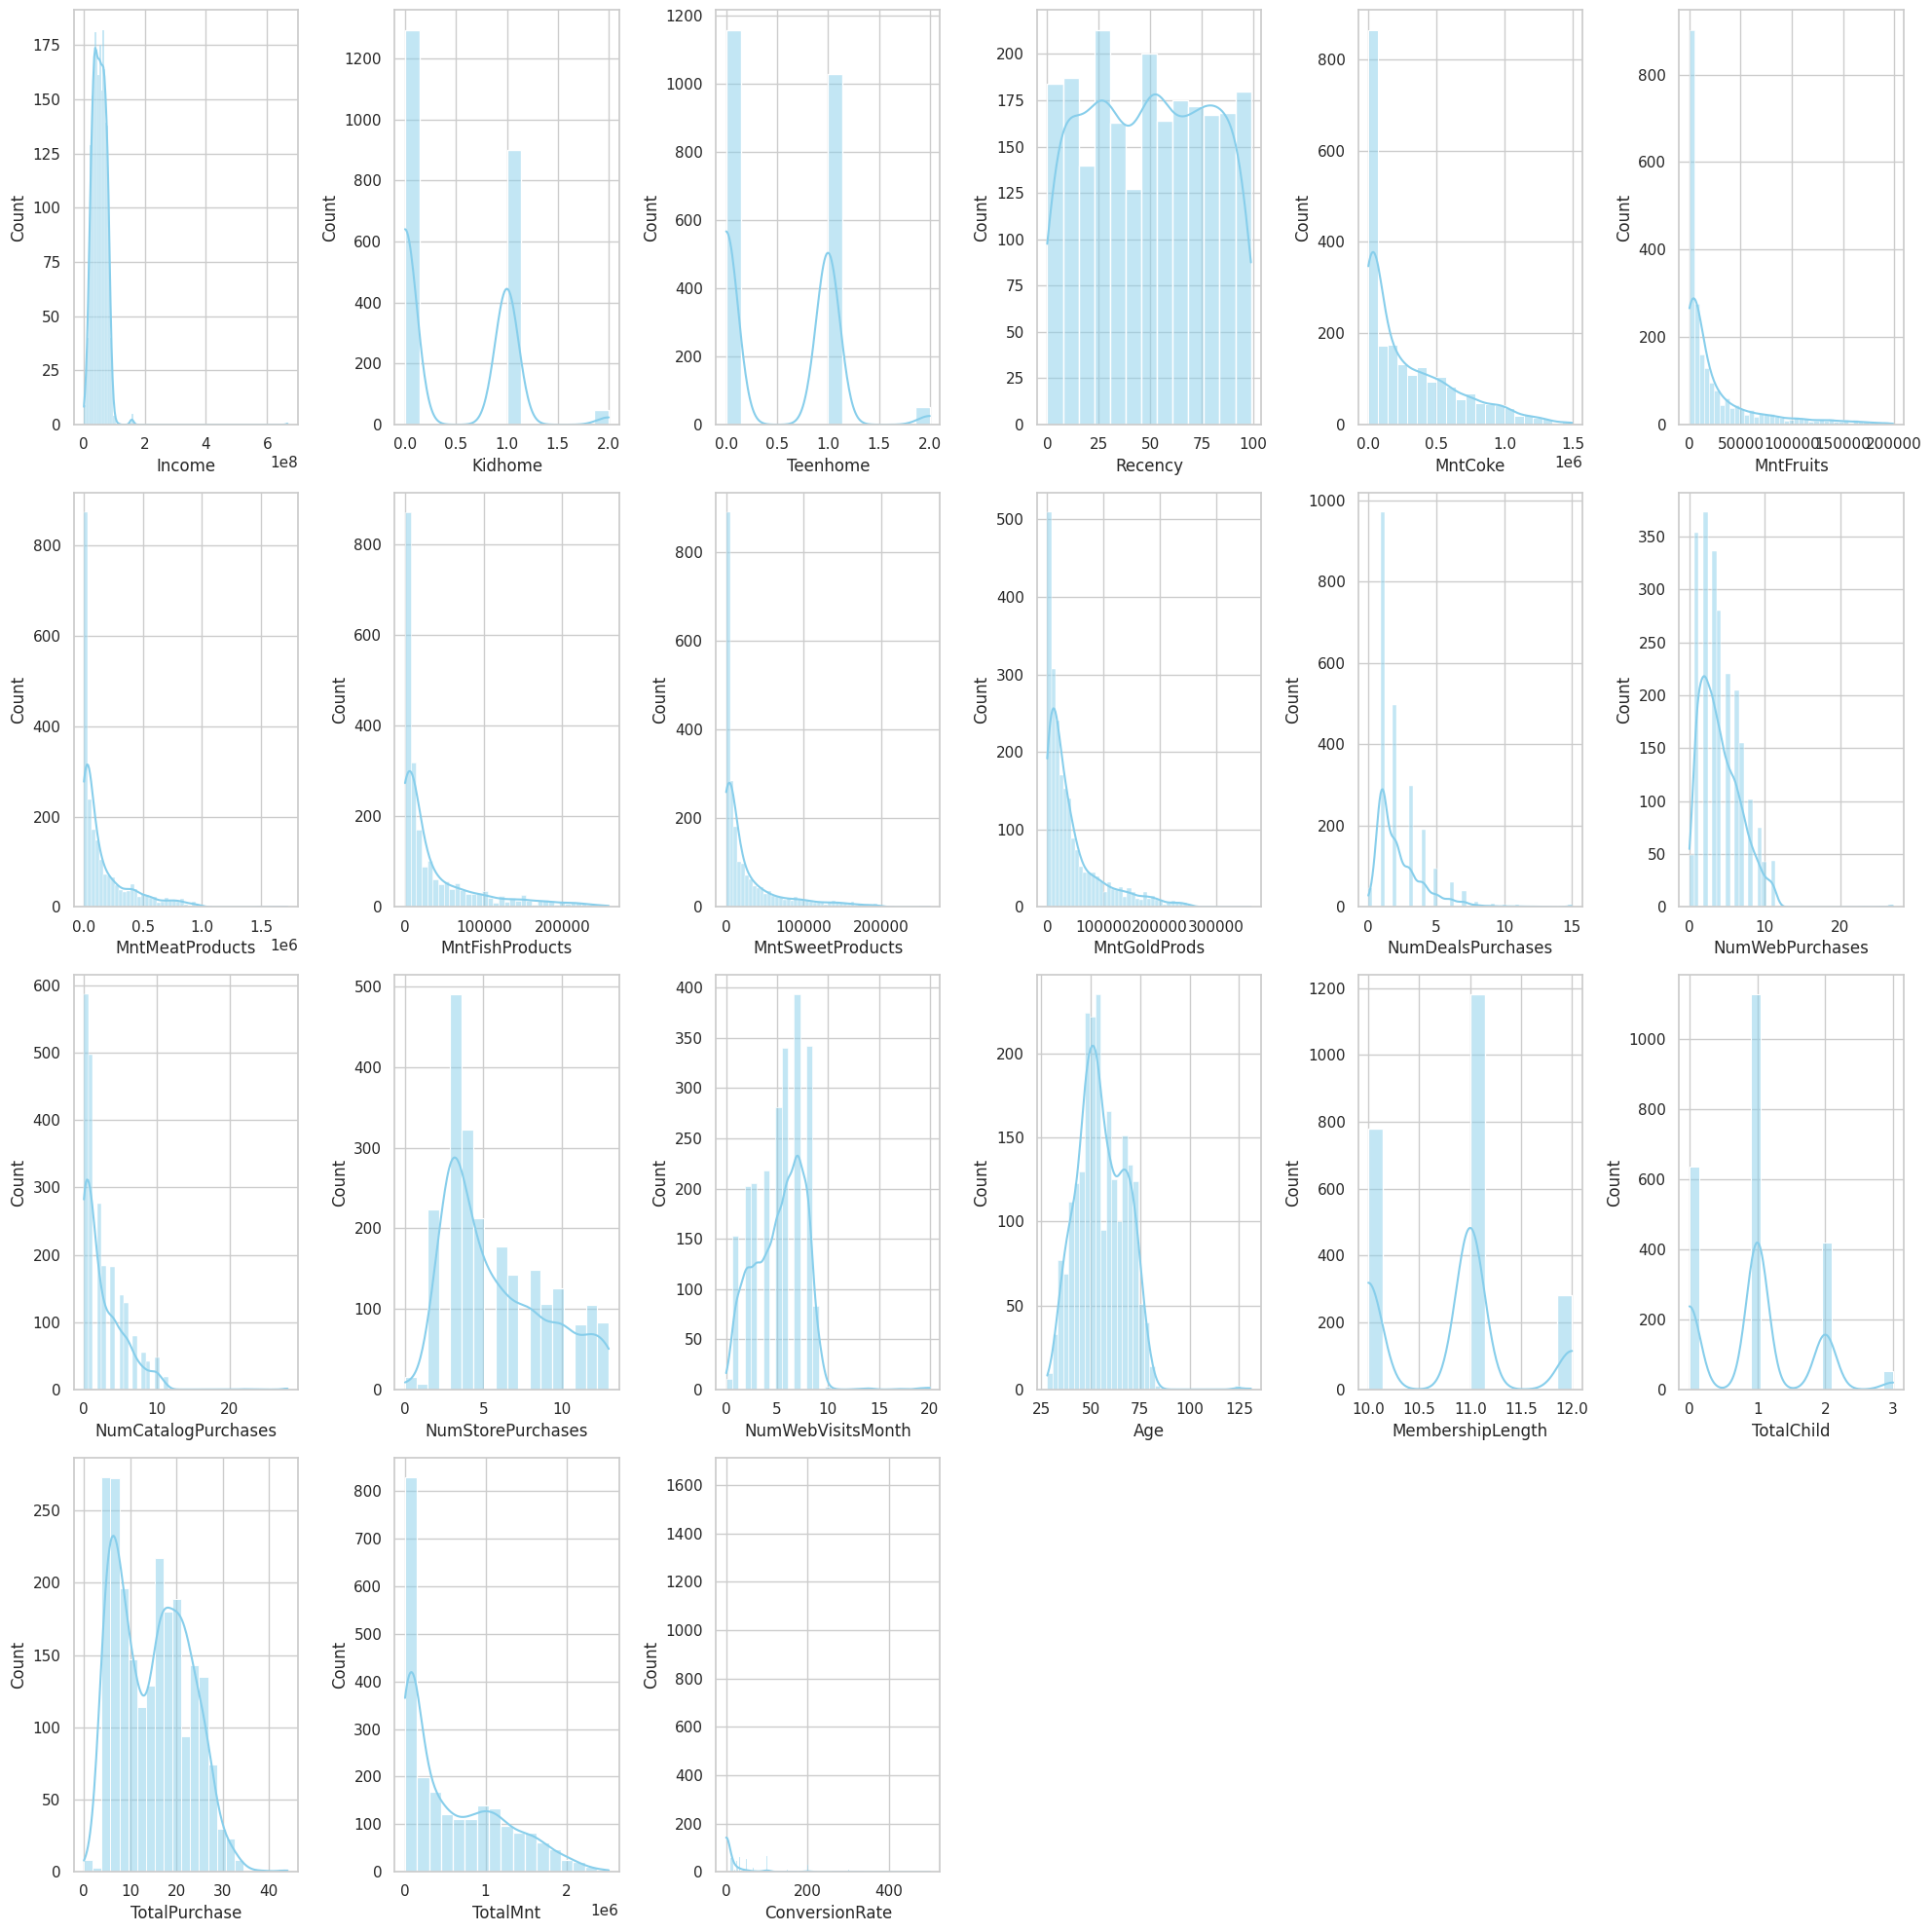

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'numeric' is your list of numeric columns
numeric = data['numeric']

# Define number of rows and columns
n_cols = 6  # 4 plots per row
n_rows = len(numeric) // n_cols + (len(numeric) % n_cols > 0)  # Calculate the number of rows

plt.figure(figsize=(20, n_rows * 5))  # Adjust figure size based on rows

for i in range(len(numeric)):
    plt.subplot(n_rows, n_cols, i + 1)  # Create subplots with multiple rows
    sns.histplot(dfn[numeric[i]], kde=True, color='skyblue')
    plt.tight_layout()

plt.show()

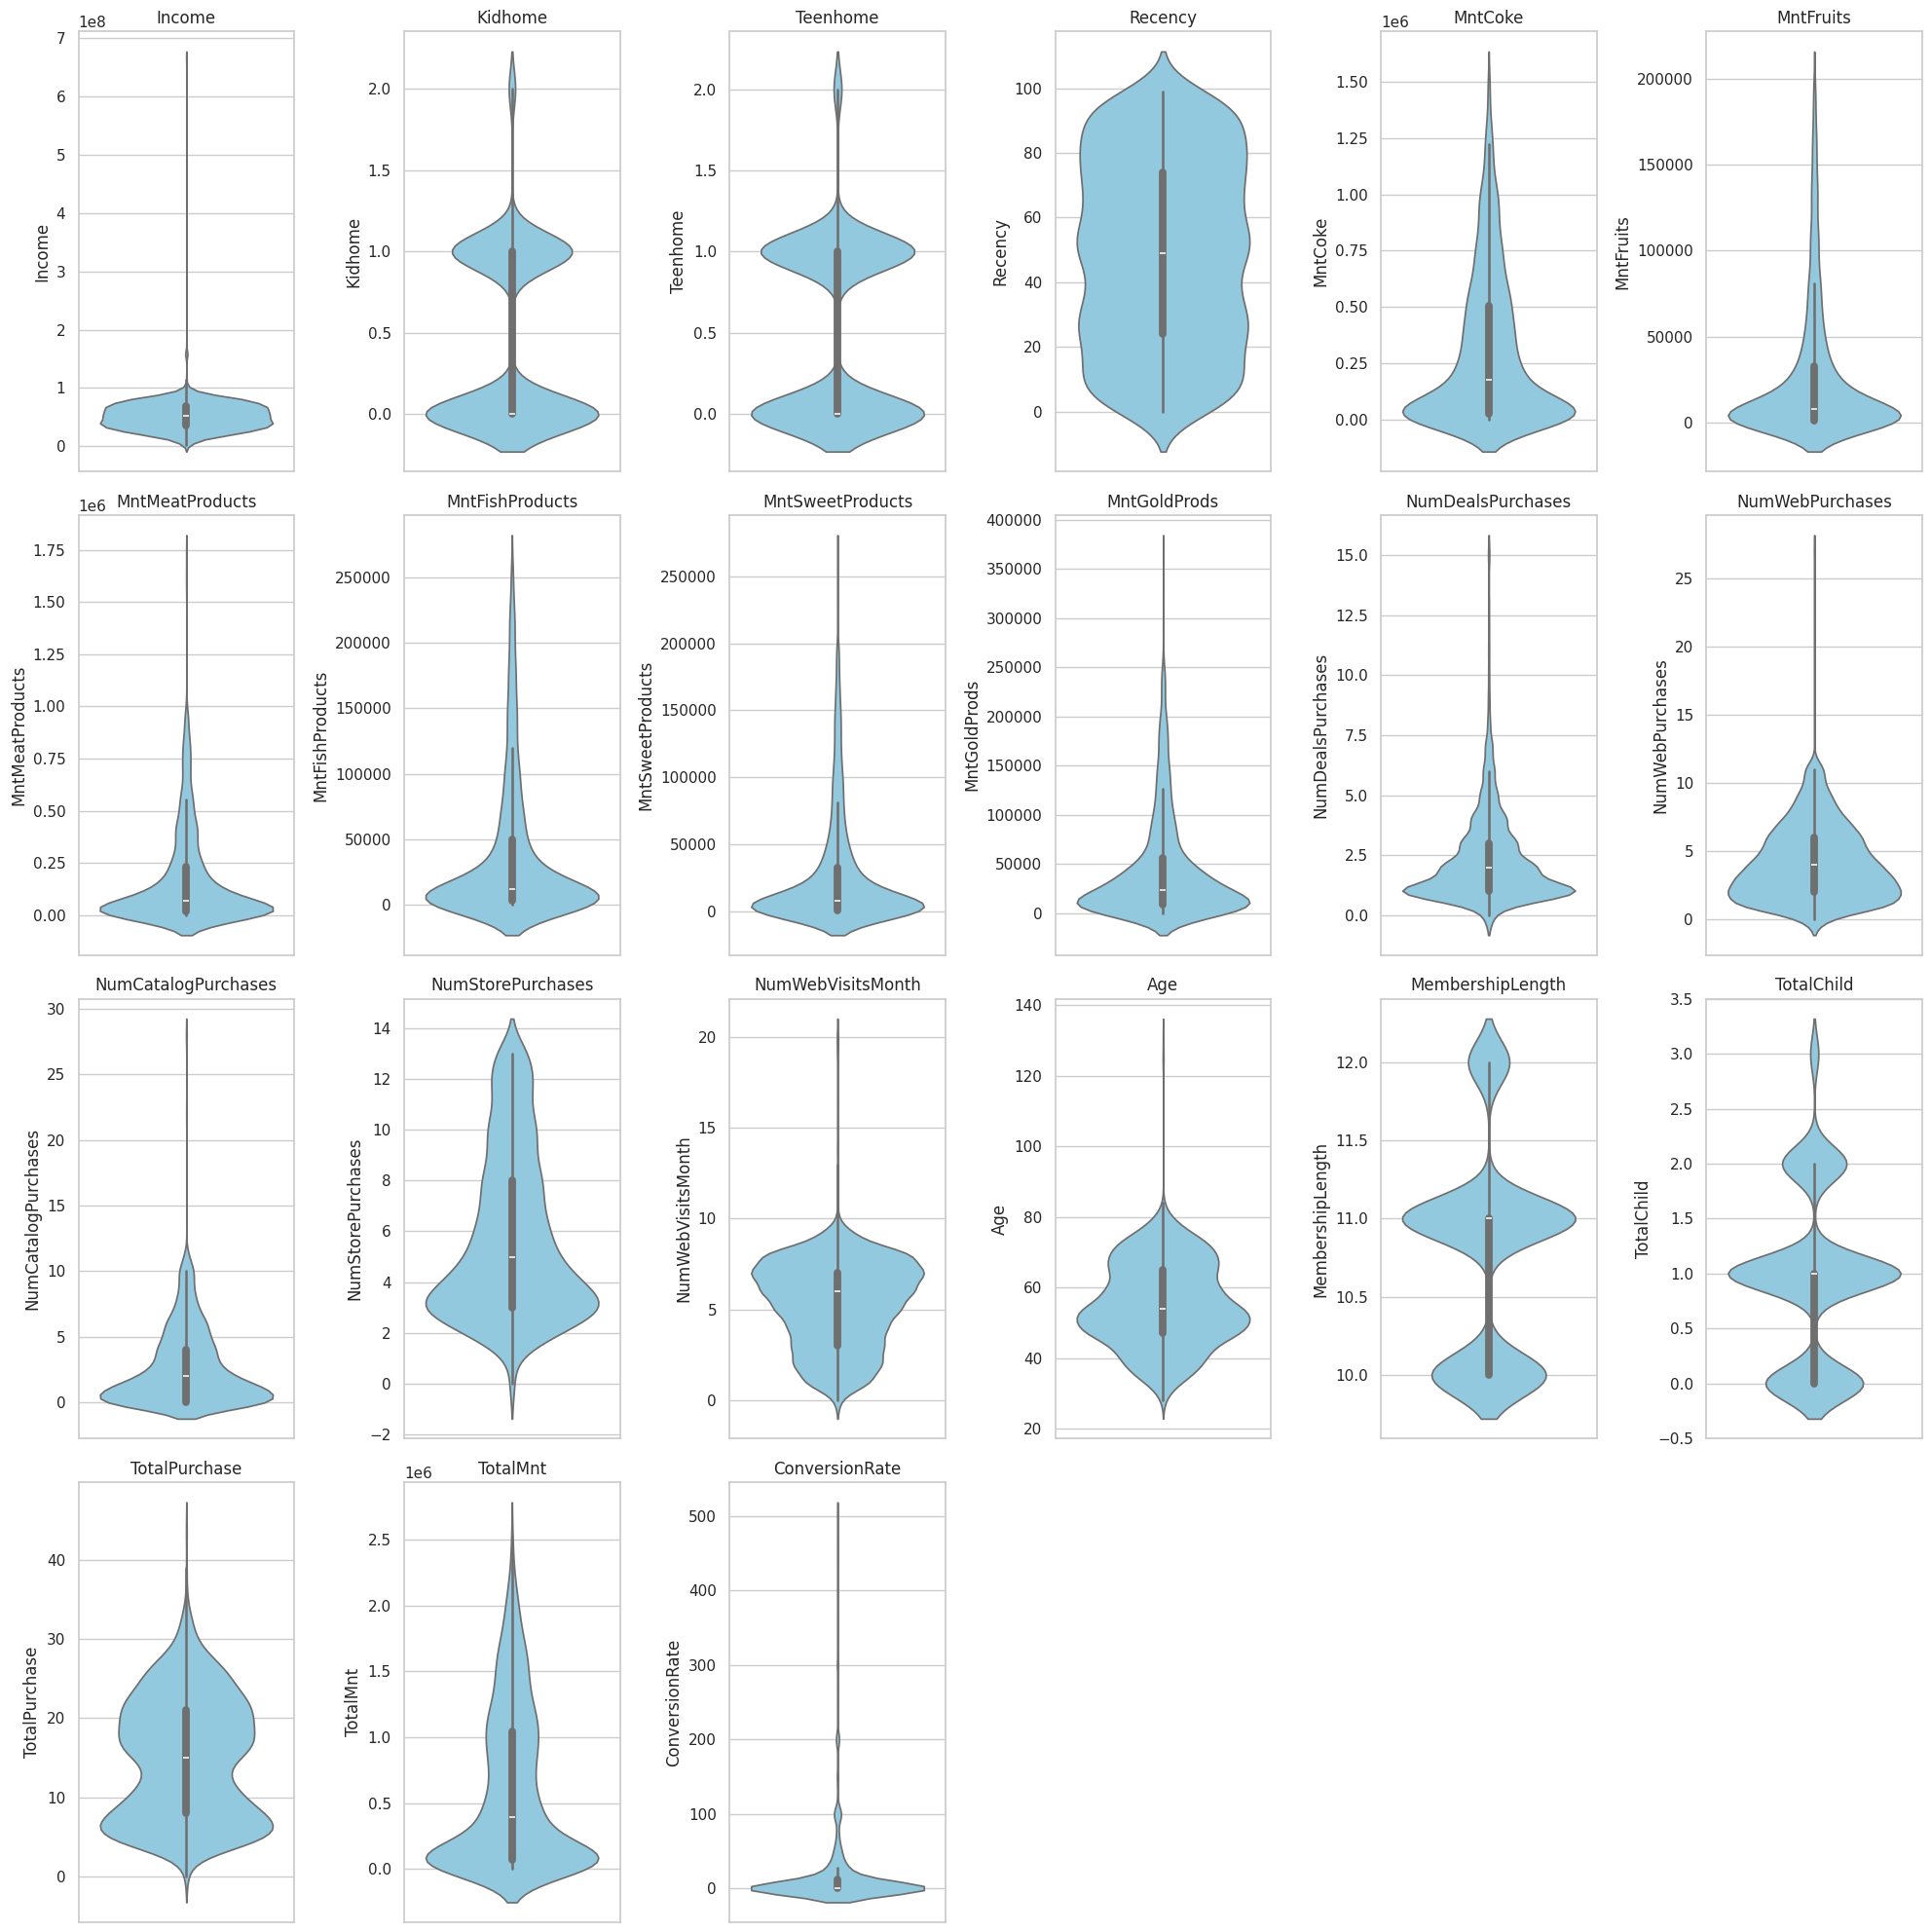

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Assuming 'numeric' is your list of numeric columns
numeric = data['numeric']  # Replace with your actual numeric data

# Define number of rows and columns
n_cols = 6  # 6 plots per row
n_rows = len(numeric) // n_cols + (len(numeric) % n_cols > 0)  # Calculate the number of rows

plt.figure(figsize=(20, n_rows * 5))  # Adjust figure size based on number of rows

# Loop through each numeric column and plot the violin plot
for i in range(len(numeric)):
    plt.subplot(n_rows, n_cols, i + 1)  # Create subplots
    sns.violinplot(y=dfn[numeric[i]], color='skyblue')  # Violin plot for each column
    plt.title(numeric[i])  # Add title with column name
    plt.tight_layout()

plt.show()

#### Age

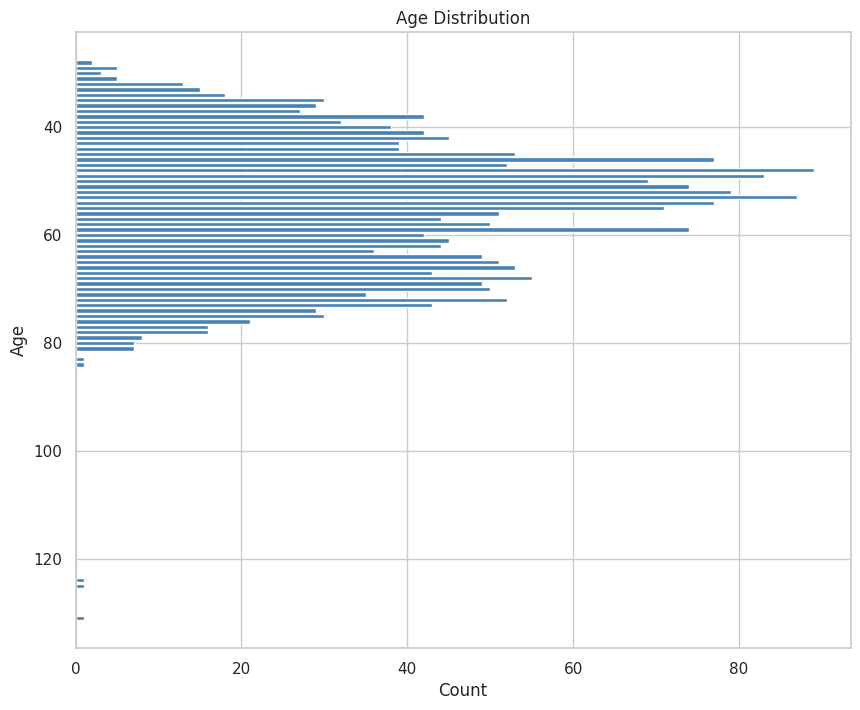

In [147]:
import matplotlib.pyplot as plt

# Assuming 'Age' is the column with age data
age_counts = dfn['Age'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 8))
plt.barh(age_counts.index, age_counts.values, color='steelblue')
plt.xlabel('Count')
plt.ylabel('Age')
plt.title('Age Distribution')
plt.gca().invert_yaxis()  # To invert the y-axis to match the example
plt.show()


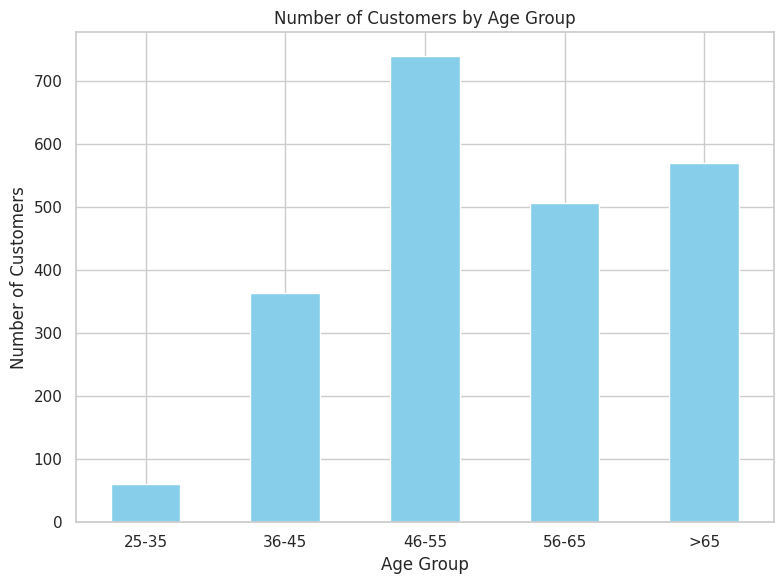

AgeGroup
25-35     61
36-45    363
46-55    740
56-65    506
>65      569
Name: count, dtype: int64


In [148]:
# Define bins and labels
bins = [25, 35, 45, 55, 65, 131]  # Age ranges: 25-35, 36-45, ..., >65
labels = ['25-35', '36-45', '46-55', '56-65', '>65']

# Create a new column 'AgeGroup' based on the bins
dfn['AgeGroup'] = pd.cut(dfn['Age'], bins=bins, labels=labels, right=False)

# Count the number of customers in each age group
age_group_counts = dfn['AgeGroup'].value_counts().sort_index()  # Sort by age group order

# Plot the bar chart
plt.figure(figsize=(8, 6))
age_group_counts.plot(kind='bar', color='skyblue')

# Add titles and labels
plt.title('Number of Customers by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.tight_layout()

# Display the plot
plt.show()

# Optional: Display the counts in a table (if you want to print the table)
print(age_group_counts)

### Education

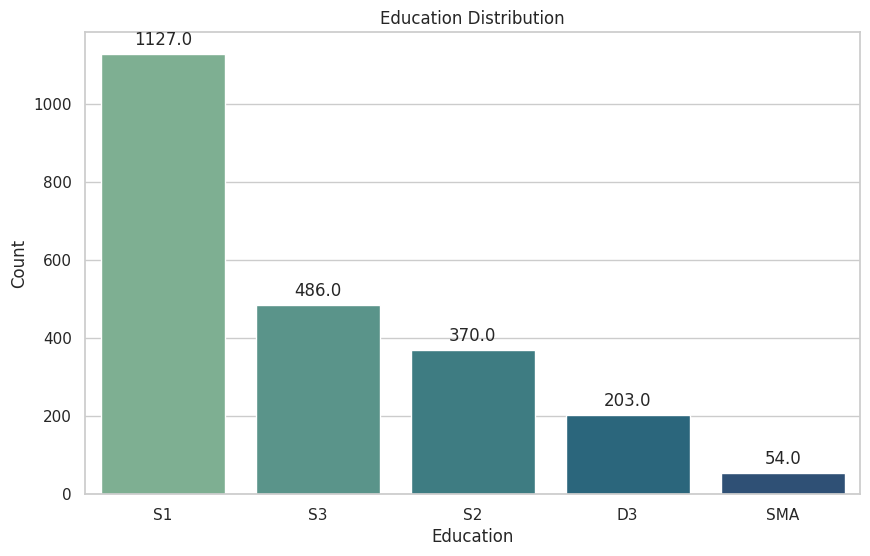

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Education' is the column with education data
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=dfn, x='Education', palette='crest', order=dfn['Education'].value_counts().index)
plt.title('Education Distribution')
plt.xlabel('Education')
plt.ylabel('Count')

# Add annotations on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10), textcoords='offset points')
plt.show()


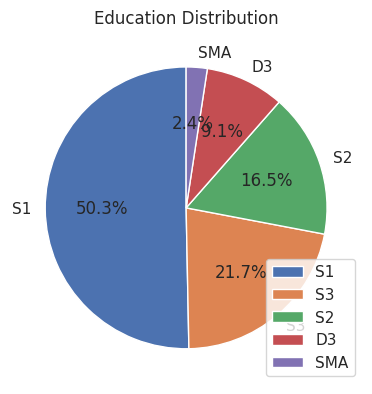

In [150]:
# Pie chart for 'education'
education_counts = dfn['Education'].value_counts()  # Count occurrences of each category
plt.figure(figsize=(10, 5))  # Set figure size
plt.subplot(1, 2, 1)  # Create a subplot for education (1 row, 2 columns, first plot)
plt.pie(education_counts, labels=education_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Education Distribution')
plt.legend(education_counts.index, loc="best")

### Marital Status

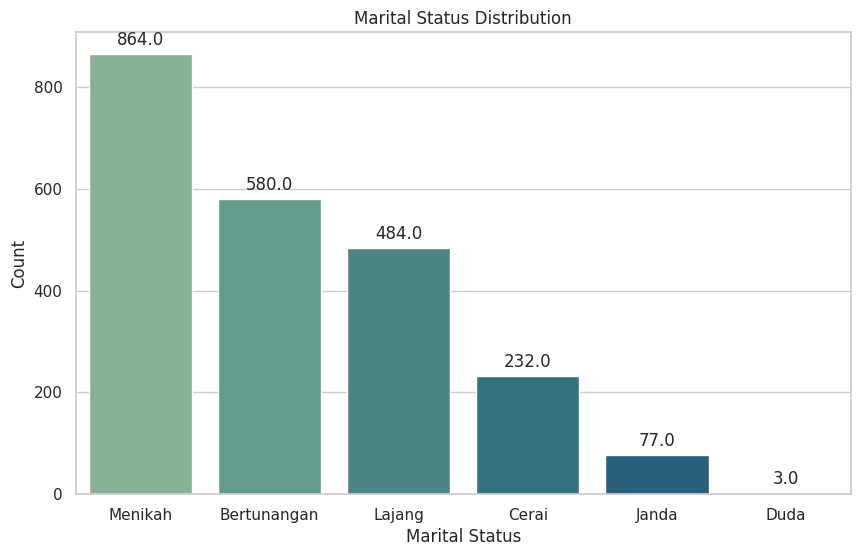

In [151]:
# Assuming 'MaritalStatus' is the column with marital status data
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=dfn, x='Marital_Status', palette='crest',  order=dfn['Marital_Status'].value_counts().index)
plt.title('Marital Status Distribution')
plt.xlabel('Marital Status')
plt.ylabel('Count')

# Add annotations on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10), textcoords='offset points')

plt.show()

### Kidhome and Teenhome

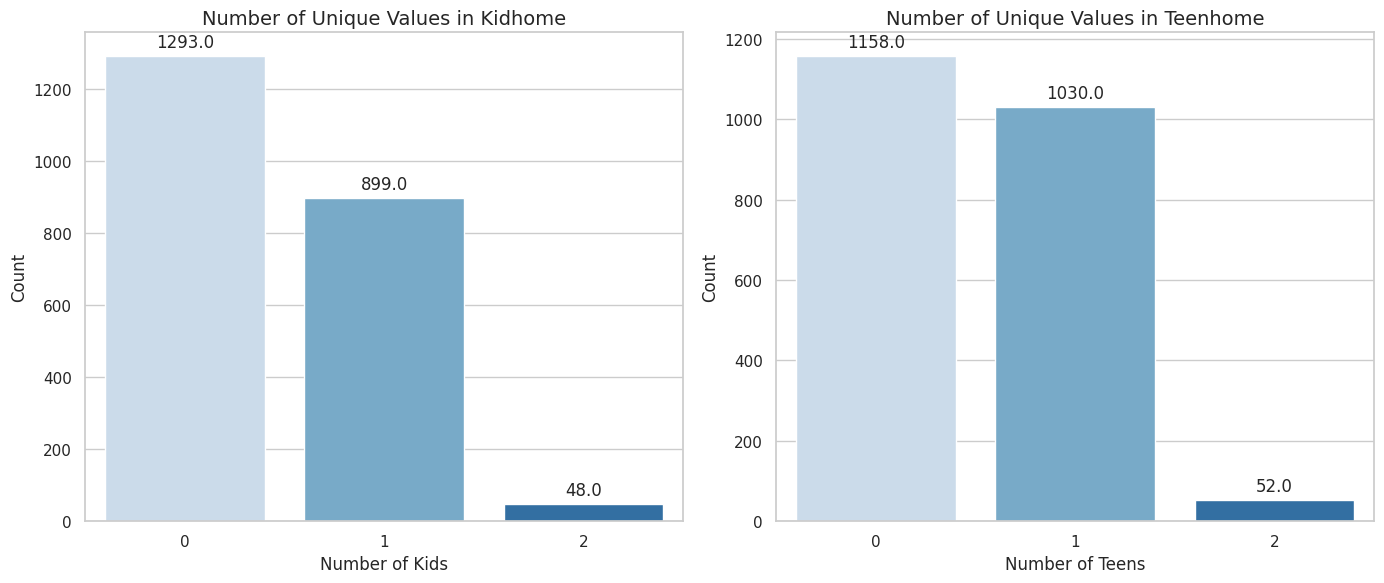

In [152]:
# Count the unique values in 'Kidhome' and 'Teenhome'
kidhome_counts = dfn['Kidhome'].value_counts().sort_index()
teenhome_counts = dfn['Teenhome'].value_counts().sort_index()

# Create subplots for side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart for 'Kidhome'
ax=sns.barplot(x=kidhome_counts.index, y=kidhome_counts.values, ax=axes[0], palette='Blues')
axes[0].set_title('Number of Unique Values in Kidhome', fontsize=14)
axes[0].set_xlabel('Number of Kids', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Add annotations on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10), textcoords='offset points')

# Bar chart for 'Teenhome'
ax=sns.barplot(x=teenhome_counts.index, y=teenhome_counts.values, ax=axes[1], palette='Blues')
axes[1].set_title('Number of Unique Values in Teenhome', fontsize=14)
axes[1].set_xlabel('Number of Teens', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

# Add annotations on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()

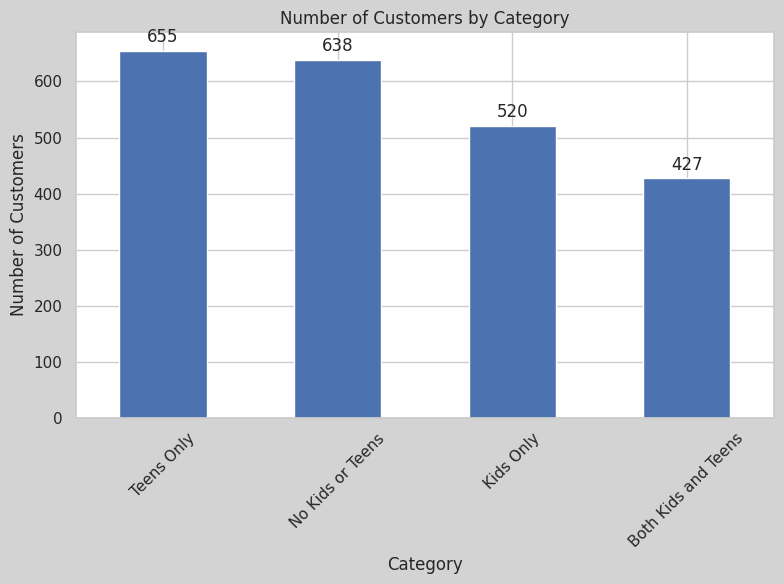

In [153]:
# Assuming df is your DataFrame
# Categorize customers
df['HasKid'] = df['Kidhome'] > 0
df['HasTeen'] = df['Teenhome'] > 0

# Create categories for Kid, Teen, and Both
df['Category'] = 'No Kids or Teens'
df.loc[df['HasKid'] & ~df['HasTeen'], 'Category'] = 'Kids Only'
df.loc[~df['HasKid'] & df['HasTeen'], 'Category'] = 'Teens Only'
df.loc[df['HasKid'] & df['HasTeen'], 'Category'] = 'Both Kids and Teens'

# Count the number of customers in each category
category_counts = df['Category'].value_counts()

# Bar plot to visualize
plt.figure(figsize=(8, 6), facecolor='lightgrey')
ax = category_counts.plot(kind='bar')
plt.title('Number of Customers by Category')
plt.xlabel('Category')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()

# Add annotations on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10), textcoords='offset points')
plt.show()

### Expenses

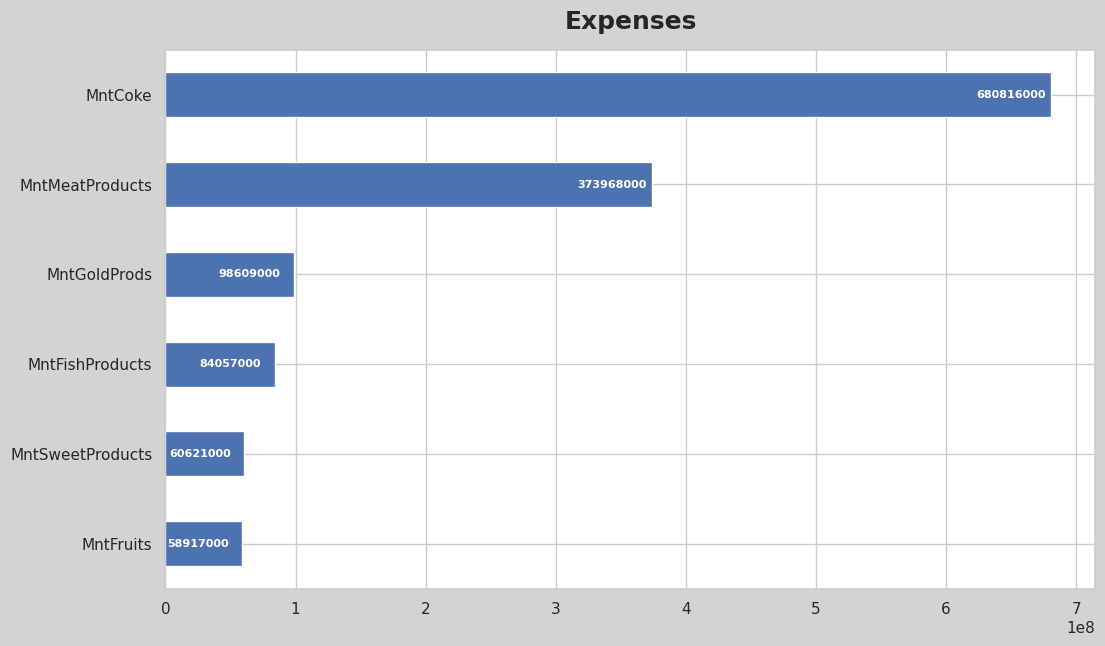

In [154]:
plt.figure(figsize=(12,7), facecolor='lightgrey')
ax = dfn[['MntCoke','MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts','MntGoldProds']].sum().sort_values(ascending=True).plot(kind='barh')
plt.title('Expenses', pad=15, fontsize=18, fontweight='semibold')
rects = ax.patches

for rect in rects:
  x_value = rect.get_width()
  y_value = rect.get_y() + rect.get_height() / 2
  plt.annotate('{}'.format(x_value), (x_value, y_value), xytext=(-54, 0),
               textcoords='offset points', va='center', ha='left', color = 'white', fontsize=8, fontweight='semibold')

### Campaign

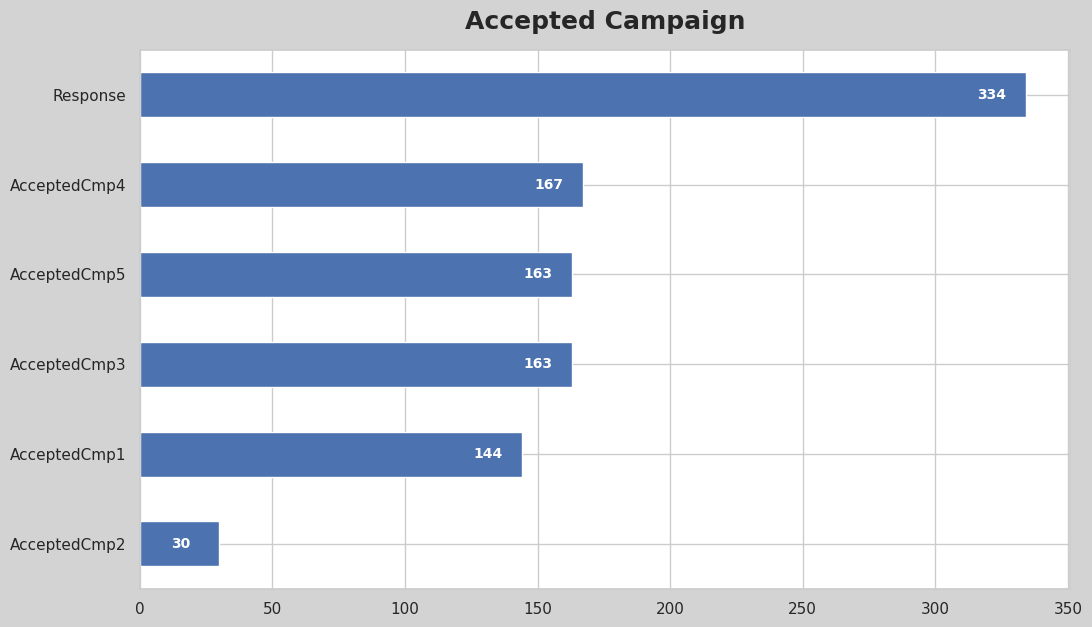

In [155]:
plt.figure(figsize=(12,7), facecolor='lightgrey')
ax = dfn[['Response','AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum().sort_values(ascending=True).plot(kind='barh')
plt.title('Accepted Campaign', pad=15, fontsize=18, fontweight='semibold')
rects = ax.patches

for rect in rects:
  x_value = rect.get_width()
  y_value = rect.get_y() + rect.get_height() / 2
  plt.annotate('{}'.format(x_value), (x_value, y_value), xytext=(-35, 0),
               textcoords='offset points', va='center', ha='left', color = 'white', fontsize=10, fontweight='semibold')

In [156]:
import pandas as pd

# Assuming df is your DataFrame
campaigns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']
data = {'Campaign': [], 'Total Customers': [], 'Responses': [], 'No Responses': []}

# Calculate counts for each campaign
for campaign in campaigns:
    total_customers = df[campaign].notna().sum()   # Total customers who received the campaign
    responses = df[df[campaign] == 1].shape[0]     # Count of customers who responded
    no_responses = df[df[campaign] == 0].shape[0]  # Count of customers who did not respond

    # Append data to the table
    data['Campaign'].append(campaign)
    data['Total Customers'].append(total_customers)
    data['Responses'].append(responses)
    data['No Responses'].append(no_responses)

# Create a DataFrame from the data dictionary
summary_df = pd.DataFrame(data)

# Display the table
print(summary_df)


       Campaign  Total Customers  Responses  No Responses
0  AcceptedCmp1             2240        144          2096
1  AcceptedCmp2             2240         30          2210
2  AcceptedCmp3             2240        163          2077
3  AcceptedCmp4             2240        167          2073
4  AcceptedCmp5             2240        163          2077
5      Response             2240        334          1906


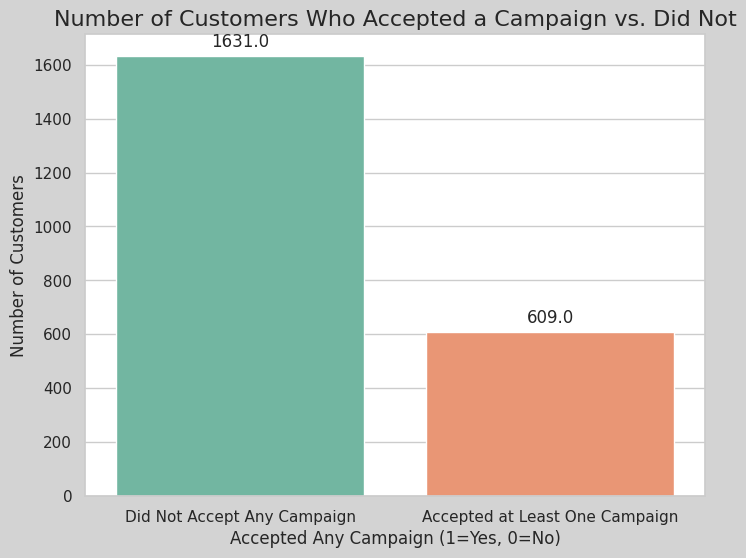

In [157]:
# Sum all the 'AcceptedCmp' columns to see if any campaign was accepted
df['AnyCampaignAccepted'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum(axis=1)

# Create a new column that checks if any campaign was accepted (1 if yes, 0 if no)
df['GotAnyCampaign'] = df['AnyCampaignAccepted'].apply(lambda x: 1 if x > 0 else 0)

# Count the number of customers who accepted at least one campaign and those who didn't
campaign_counts = df['GotAnyCampaign'].value_counts()

# 1. Bar Chart
plt.figure(figsize=(8, 6), facecolor='lightgrey')
ax = sns.barplot(x=campaign_counts.index, y=campaign_counts.values, palette='Set2')
plt.title('Number of Customers Who Accepted a Campaign vs. Did Not', fontsize=16)
plt.xlabel('Accepted Any Campaign (1=Yes, 0=No)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks([0, 1], ['Did Not Accept Any Campaign', 'Accepted at Least One Campaign'])

# Add annotations on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10), textcoords='offset points')
plt.show()

### Purchases

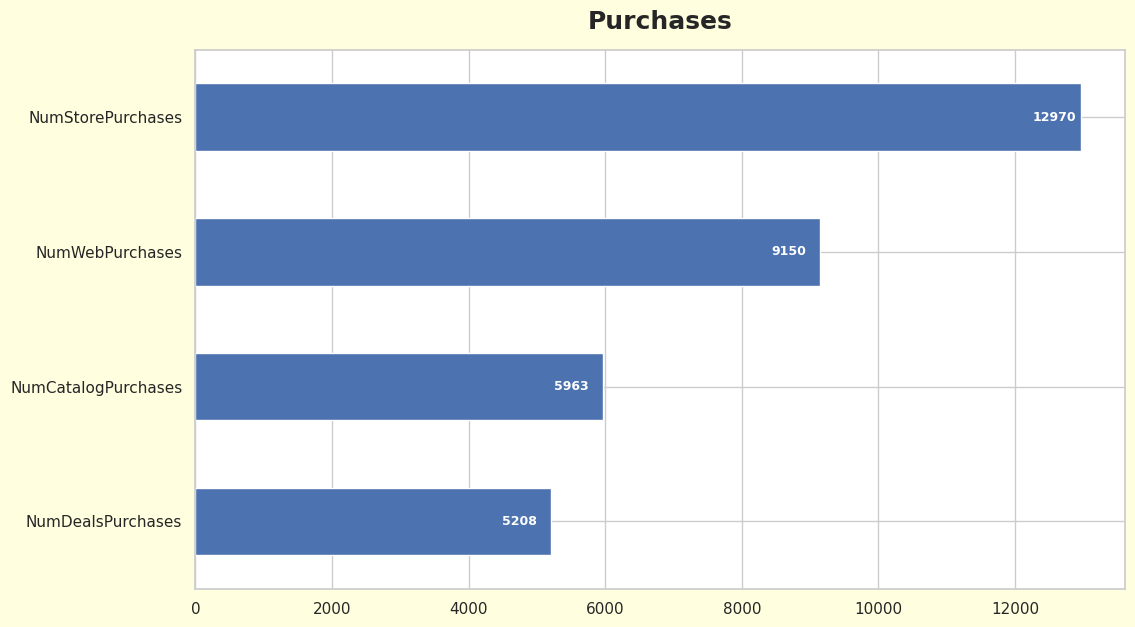

In [158]:
plt.figure(figsize=(12,7), facecolor='lightyellow')
ax = dfn[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum().sort_values(ascending=True).plot(kind='barh')
plt.title('Purchases', pad=15, fontsize=18, fontweight='semibold')
rects = ax.patches

for rect in rects:
  x_value = rect.get_width()
  y_value = rect.get_y() + rect.get_height() / 2
  plt.annotate('{}'.format(x_value), (x_value, y_value), xytext=(-35, 0),
              textcoords='offset points', va='center', ha='left', color = 'white', fontsize=9, fontweight='semibold')

### Complain

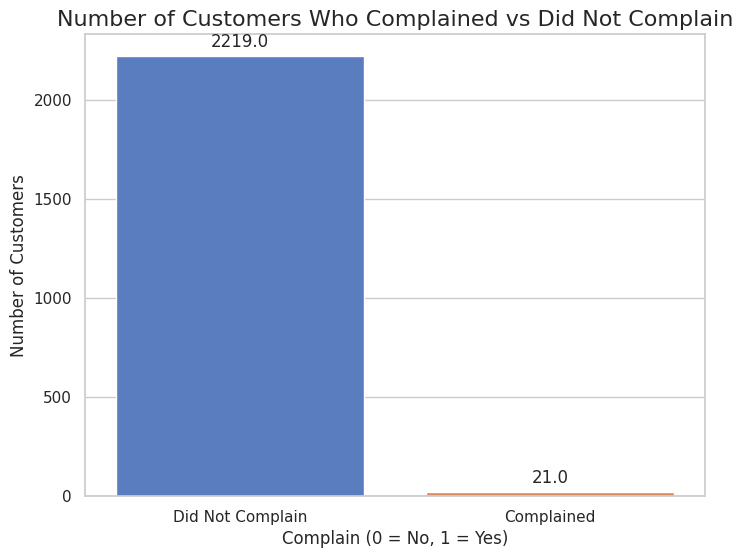

In [159]:
# Count the number of customers who complained and who didn't
complain_counts = df['Complain'].value_counts()

# 1. Bar Chart
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=complain_counts.index, y=complain_counts.values, palette='muted')
plt.title('Number of Customers Who Complained vs Did Not Complain', fontsize=16)
plt.xlabel('Complain (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks([0, 1], ['Did Not Complain', 'Complained'])

# Add annotations on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10), textcoords='offset points')

plt.show()

# EDA Multivariat

In [160]:
print(dfn.columns)

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'MntCoke', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact',
       'Z_Revenue', 'Response', 'TotalResponses', 'Age', 'MembershipLength',
       'TotalChild', 'TotalPurchase', 'TotalMnt', 'education_encoded',
       'ConversionRate', 'MadePurchase', 'AgeGroup'],
      dtype='object')


In [161]:
#pemisahan data categoricals & numericals
data = {
    'category': ['Education', 'Marital_Status', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5' 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'MadePurchase'],
    'numeric': ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntCoke',
                'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
                'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'MembershipLength',
                'TotalChild', 'TotalPurchase', 'TotalMnt', 'ConversionRate']}

### Expenses

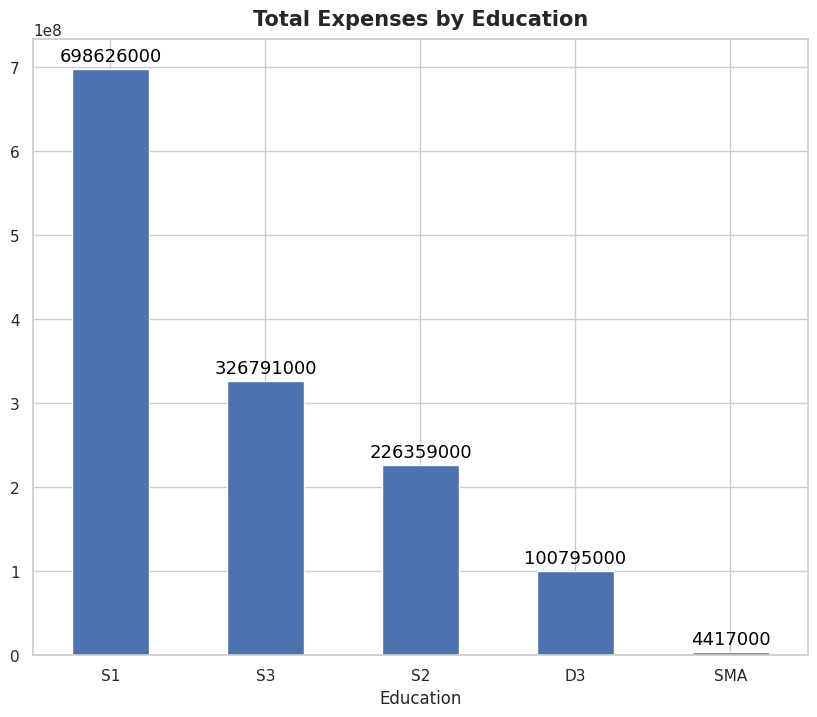

In [162]:
sns.set(style='whitegrid')
ax = df[['Education','TotalMnt']].groupby('Education').sum().sort_values(by='TotalMnt', ascending=False).plot(kind='bar', figsize=(10,8), legend=None)
plt.xticks(rotation=360)
plt.title('Total Expenses by Education', pad=10, fontsize=15, fontweight='semibold')

for p in ax.patches:
  number = '{}'.format(p.get_height().astype('int64'))
  ax.annotate(number, (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center',
  xytext=(0,9), textcoords='offset points', color='black', fontsize=13)

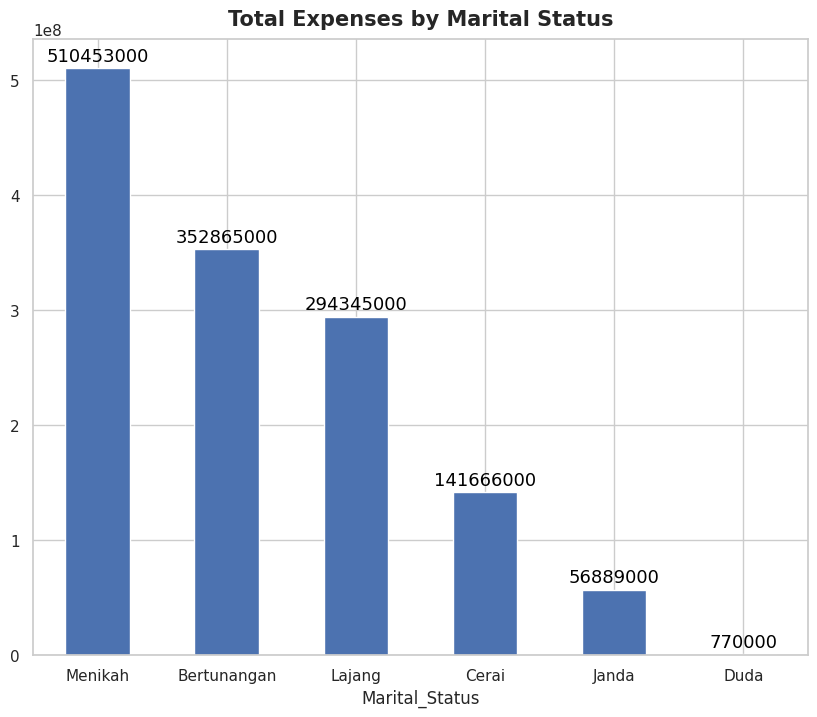

In [163]:
sns.set(style='whitegrid')
ax = df[['Marital_Status','TotalMnt']].groupby('Marital_Status').sum().sort_values(by='TotalMnt', ascending=False).plot(kind='bar', figsize=(10,8), legend=None)
plt.xticks(rotation=360)
plt.title('Total Expenses by Marital Status', pad=10, fontsize=15, fontweight='semibold')

for p in ax.patches:
  number = '{}'.format(p.get_height().astype('int64'))
  ax.annotate(number, (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center',
  xytext=(0,9), textcoords='offset points', color='black', fontsize=13)

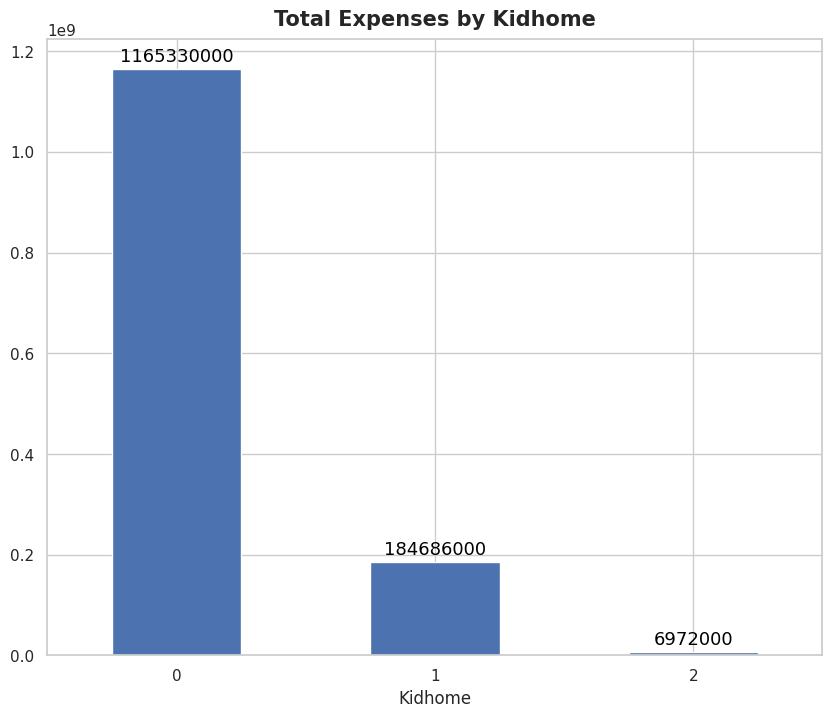

In [164]:
sns.set(style='whitegrid')
ax = df[['Kidhome','TotalMnt']].groupby('Kidhome').sum().sort_values(by='Kidhome', ascending=True).plot(kind='bar', figsize=(10,8), legend=None)
plt.xticks(rotation=360)
plt.title('Total Expenses by Kidhome', pad=10, fontsize=15, fontweight='semibold')

for p in ax.patches:
  number = '{}'.format(p.get_height().astype('int64'))
  ax.annotate(number, (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center',
  xytext=(0,9), textcoords='offset points', color='black', fontsize=13)

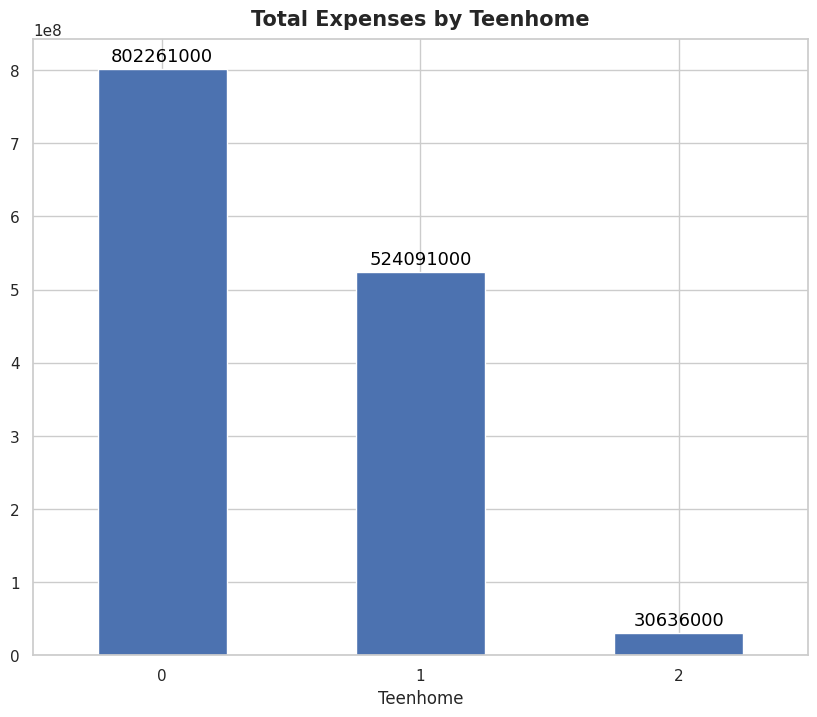

In [165]:
sns.set(style='whitegrid')
ax = df[['Teenhome','TotalMnt']].groupby('Teenhome').sum().sort_values(by='Teenhome', ascending=True).plot(kind='bar', figsize=(10,8), legend=None)
plt.xticks(rotation=360)
plt.title('Total Expenses by Teenhome', pad=10, fontsize=15, fontweight='semibold')

for p in ax.patches:
  number = '{}'.format(p.get_height().astype('int64'))
  ax.annotate(number, (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center',
  xytext=(0,9), textcoords='offset points', color='black', fontsize=13)

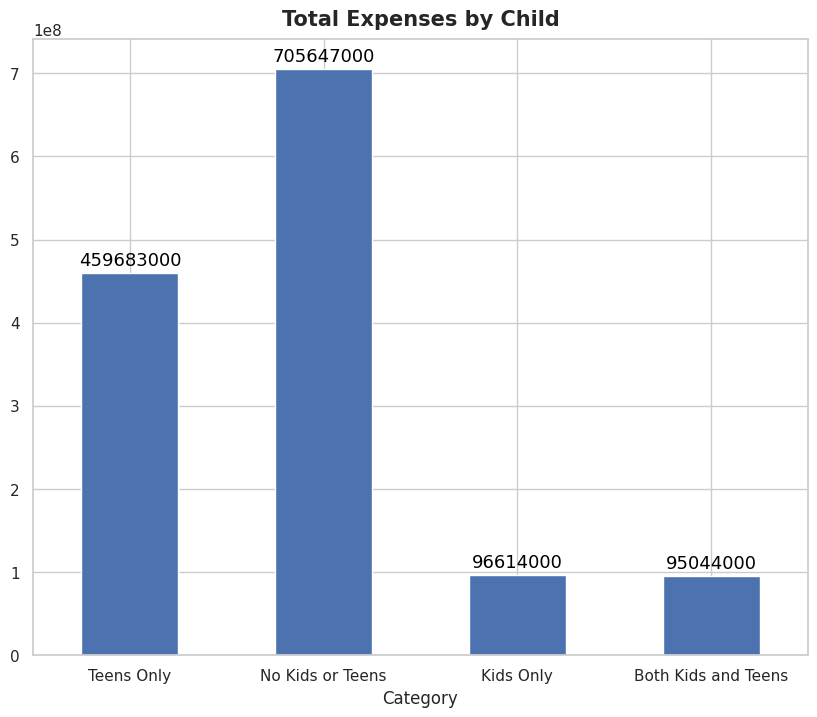

In [166]:
sns.set(style='whitegrid')
ax = df[['Category','TotalMnt']].groupby('Category').sum().sort_values(by='Category', ascending=False).plot(kind='bar', figsize=(10,8), legend=None)
plt.xticks(rotation=360)
plt.title('Total Expenses by Child', pad=10, fontsize=15, fontweight='semibold')

for p in ax.patches:
  number = '{}'.format(p.get_height().astype('int64'))
  ax.annotate(number, (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center',
  xytext=(0,9), textcoords='offset points', color='black', fontsize=13)

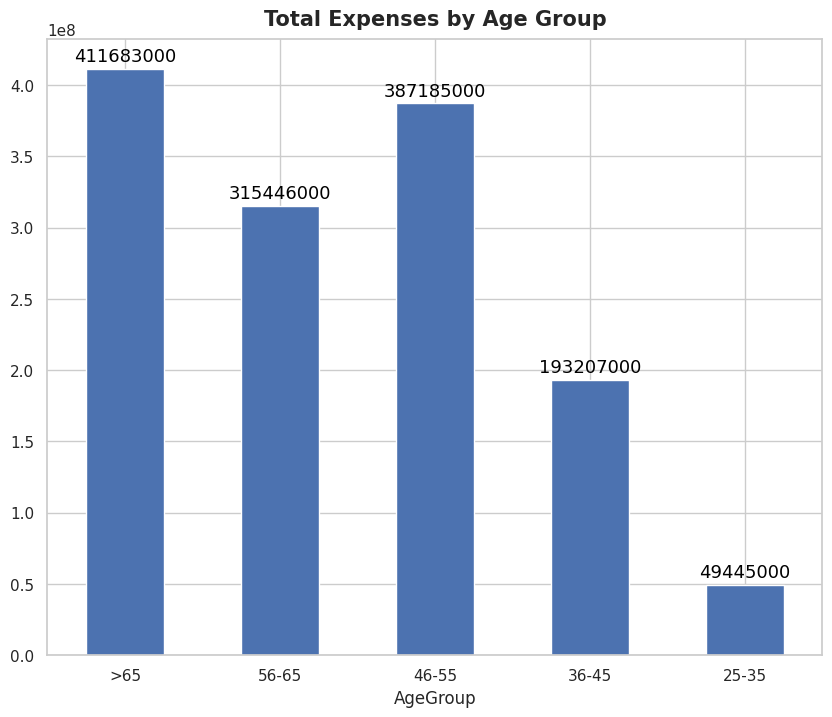

In [167]:
sns.set(style='whitegrid')
ax = dfn[['AgeGroup','TotalMnt']].groupby('AgeGroup').sum().sort_values(by='AgeGroup', ascending=False).plot(kind='bar', figsize=(10,8), legend=None)
plt.xticks(rotation=360)
plt.title('Total Expenses by Age Group', pad=10, fontsize=15, fontweight='semibold')

for p in ax.patches:
  number = '{}'.format(p.get_height().astype('int64'))
  ax.annotate(number, (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center',
  xytext=(0,9), textcoords='offset points', color='black', fontsize=13)

### Campaign

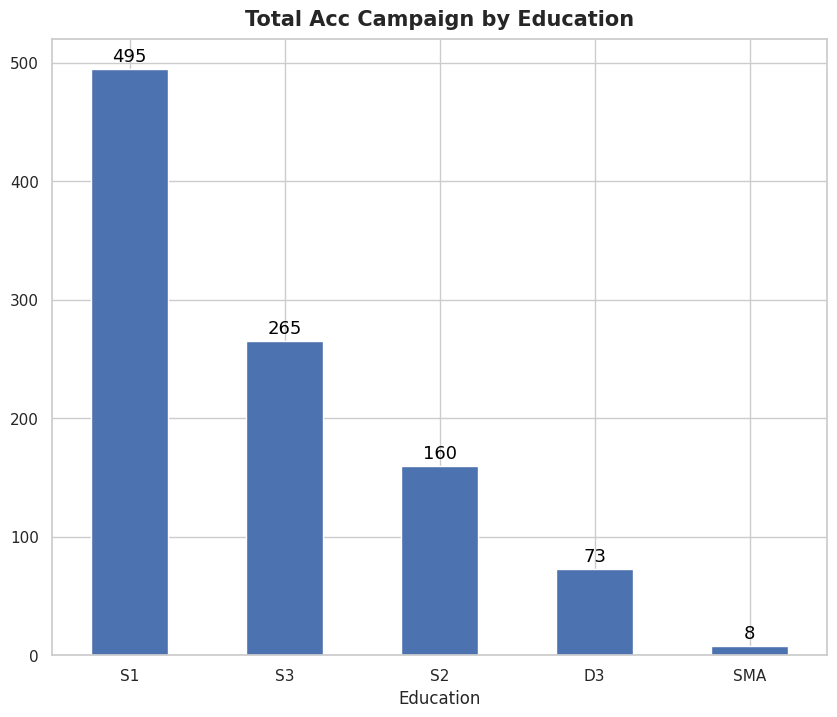

In [168]:
sns.set(style='whitegrid')
ax = df[['Education','TotalResponses']].groupby('Education').sum().sort_values(by='TotalResponses', ascending=False).plot(kind='bar', figsize=(10,8), legend=None)
plt.xticks(rotation=360)
plt.title('Total Acc Campaign by Education', pad=10, fontsize=15, fontweight='semibold')

for p in ax.patches:
  number = '{}'.format(p.get_height().astype('int64'))
  ax.annotate(number, (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center',
  xytext=(0,9), textcoords='offset points', color='black', fontsize=13)

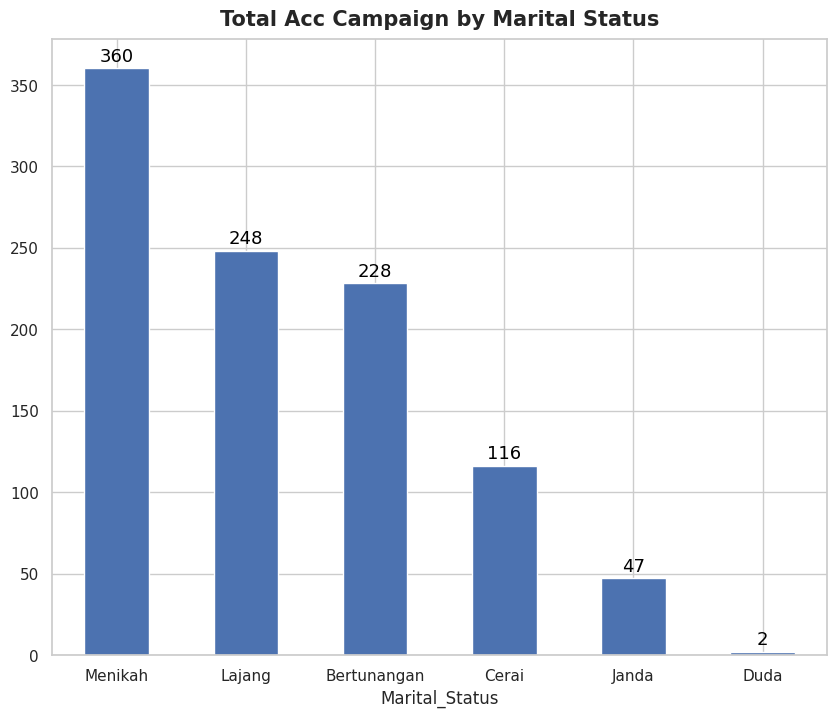

In [169]:
sns.set(style='whitegrid')
ax = df[['Marital_Status','TotalResponses']].groupby('Marital_Status').sum().sort_values(by='TotalResponses', ascending=False).plot(kind='bar', figsize=(10,8), legend=None)
plt.xticks(rotation=360)
plt.title('Total Acc Campaign by Marital Status', pad=10, fontsize=15, fontweight='semibold')

for p in ax.patches:
  number = '{}'.format(p.get_height().astype('int64'))
  ax.annotate(number, (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center',
  xytext=(0,9), textcoords='offset points', color='black', fontsize=13)

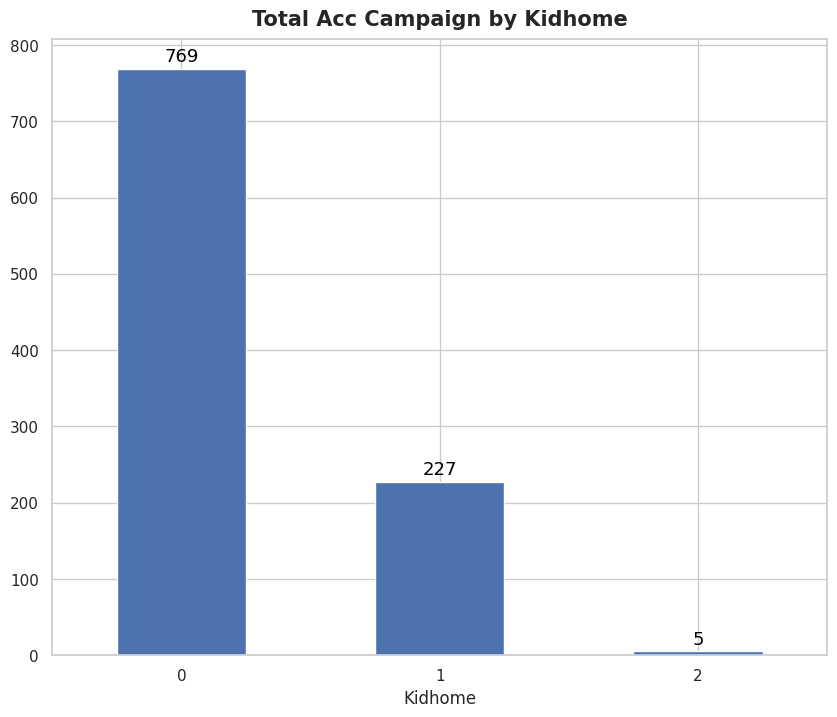

In [170]:
sns.set(style='whitegrid')
ax = df[['Kidhome','TotalResponses']].groupby('Kidhome').sum().sort_values(by='Kidhome', ascending=True).plot(kind='bar', figsize=(10,8), legend=None)
plt.xticks(rotation=360)
plt.title('Total Acc Campaign by Kidhome', pad=10, fontsize=15, fontweight='semibold')

for p in ax.patches:
  number = '{}'.format(p.get_height().astype('int64'))
  ax.annotate(number, (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center',
  xytext=(0,9), textcoords='offset points', color='black', fontsize=13)

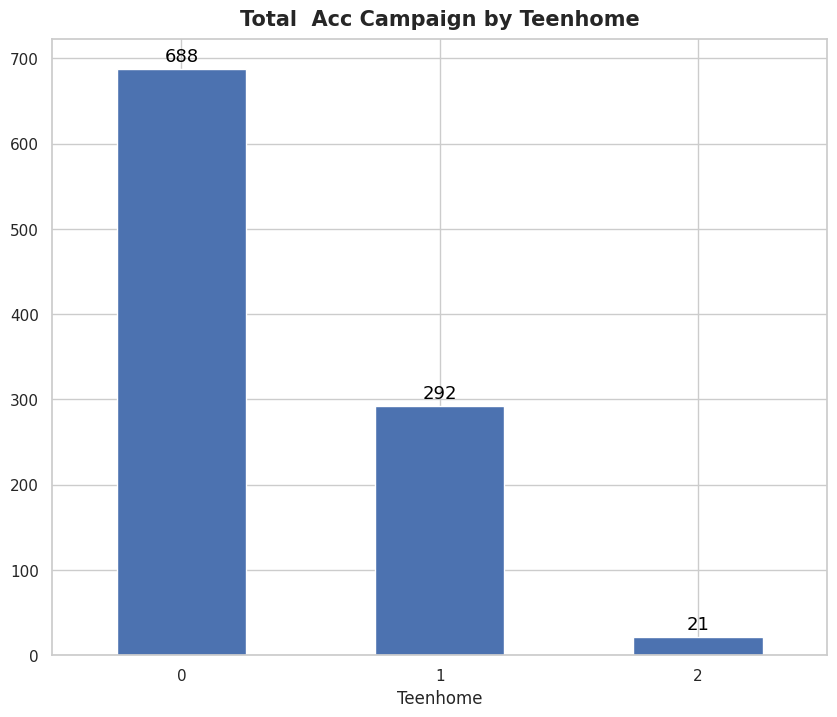

In [171]:
sns.set(style='whitegrid')
ax = df[['Teenhome','TotalResponses']].groupby('Teenhome').sum().sort_values(by='Teenhome', ascending=True).plot(kind='bar', figsize=(10,8), legend=None)
plt.xticks(rotation=360)
plt.title('Total  Acc Campaign by Teenhome', pad=10, fontsize=15, fontweight='semibold')

for p in ax.patches:
  number = '{}'.format(p.get_height().astype('int64'))
  ax.annotate(number, (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center',
  xytext=(0,9), textcoords='offset points', color='black', fontsize=13)

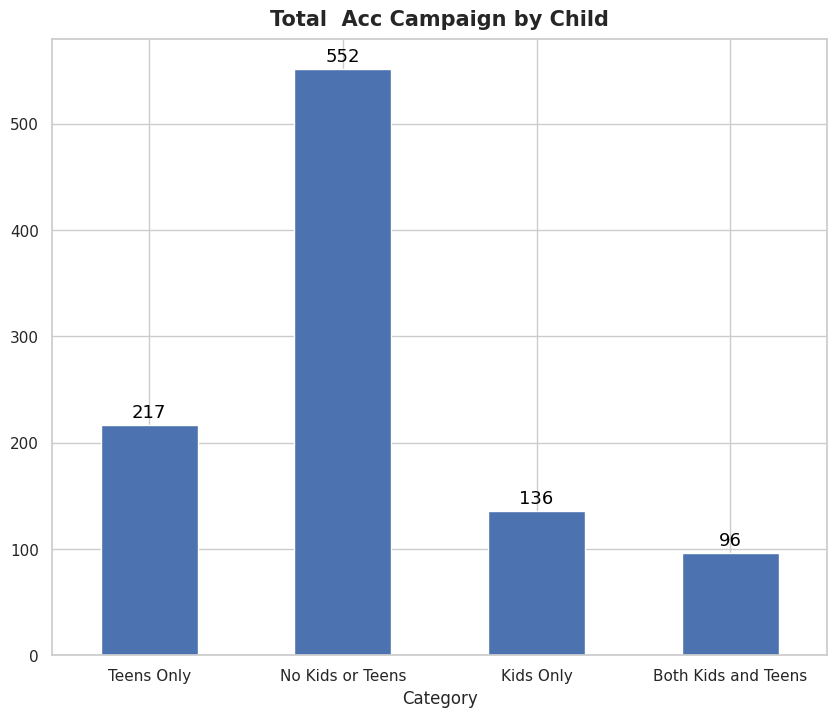

In [172]:
sns.set(style='whitegrid')
ax = df[['Category','TotalResponses']].groupby('Category').sum().sort_values(by='Category', ascending=False).plot(kind='bar', figsize=(10,8), legend=None)
plt.xticks(rotation=360)
plt.title('Total  Acc Campaign by Child', pad=10, fontsize=15, fontweight='semibold')

for p in ax.patches:
  number = '{}'.format(p.get_height().astype('int64'))
  ax.annotate(number, (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center',
  xytext=(0,9), textcoords='offset points', color='black', fontsize=13)

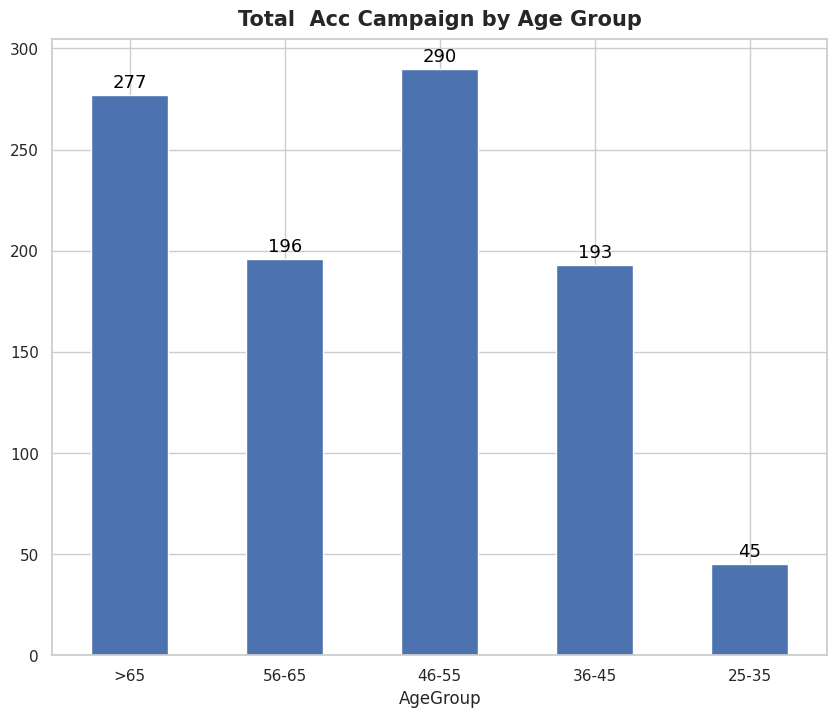

In [173]:
sns.set(style='whitegrid')
ax = dfn[['AgeGroup','TotalResponses']].groupby('AgeGroup').sum().sort_values(by='AgeGroup', ascending=False).plot(kind='bar', figsize=(10,8), legend=None)
plt.xticks(rotation=360)
plt.title('Total  Acc Campaign by Age Group', pad=10, fontsize=15, fontweight='semibold')

for p in ax.patches:
  number = '{}'.format(p.get_height().astype('int64'))
  ax.annotate(number, (p.get_x() + p.get_width()/2., p.get_height()), ha='center', va='center',
  xytext=(0,9), textcoords='offset points', color='black', fontsize=13)

In [174]:
# Create a new column 'IsParents' where value is 1 if the customer has at least one kid or teen, else 0
dfn['IsParents'] = ((dfn['Kidhome'] > 0) | (dfn['Teenhome'] > 0)).astype(int)

# Display the first few rows of the DataFrame to check the new column
print(dfn[['Kidhome', 'Teenhome', 'IsParents']].head())


   Kidhome  Teenhome  IsParents
0        0         0          0
1        1         1          1
2        0         0          0
3        1         0          1
4        1         0          1


In [175]:
print(dfn.columns)

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'MntCoke', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact',
       'Z_Revenue', 'Response', 'TotalResponses', 'Age', 'MembershipLength',
       'TotalChild', 'TotalPurchase', 'TotalMnt', 'education_encoded',
       'ConversionRate', 'MadePurchase', 'AgeGroup', 'IsParents'],
      dtype='object')


### Heatmap

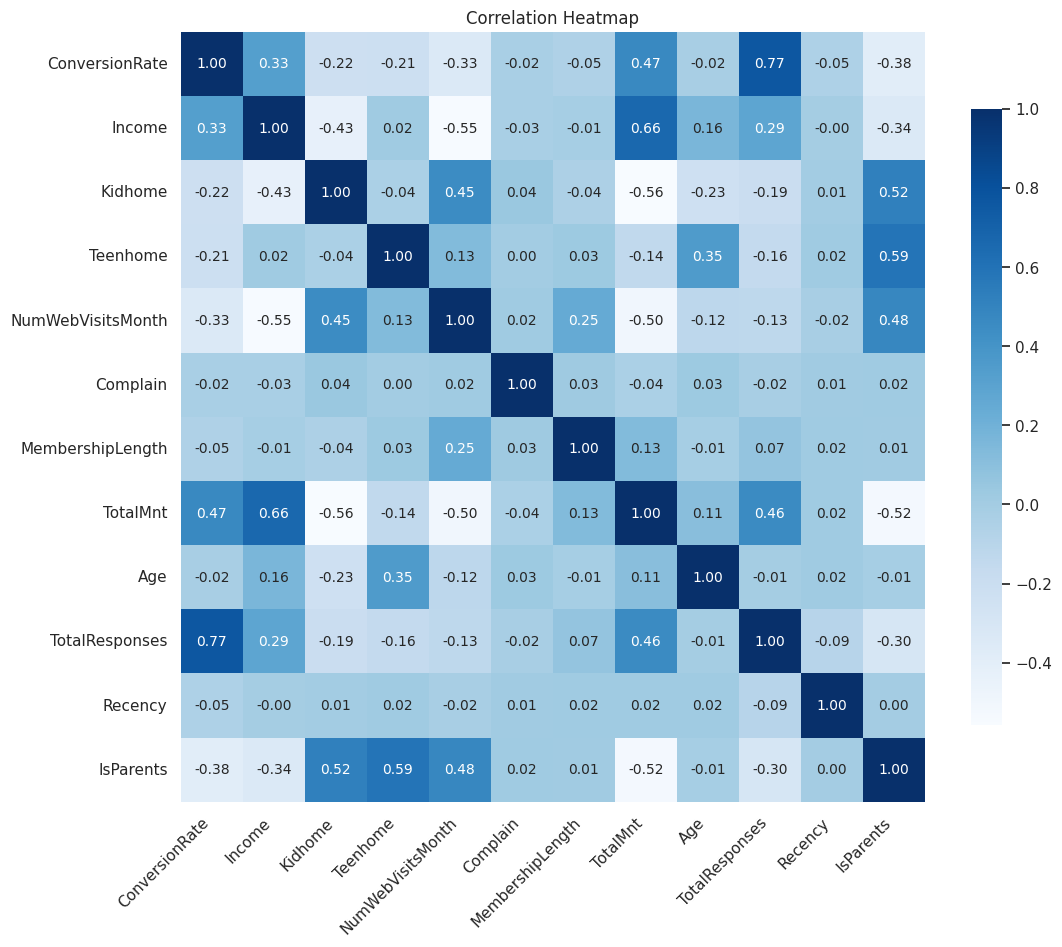

In [176]:
# Adjust figure size
plt.figure(figsize=(12, 10))

# Create heatmap with additional formatting
sns.heatmap(
    dfn[['ConversionRate', 'Income', 'Kidhome', 'Teenhome', 'NumWebVisitsMonth', 'Complain',
         'MembershipLength', 'TotalMnt', 'Age', 'TotalResponses', 'Recency', 'IsParents']].corr(),
    annot=True,          # Add annotations
    fmt='.2f',           # Format annotations to 2 decimal places
    cmap='Blues',        # Use the 'magma' color map
    annot_kws={"size": 10}, # Adjust annotation font size
    cbar_kws={'shrink': 0.8} # Shrink color bar
)

# Customize x and y ticks
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add title for clarity
plt.title('Correlation Heatmap')

# Display the heatmap
plt.show()

# Data Preparation

In [177]:
# One-hot encode the 'Marital_Status' column
df_encoded = pd.get_dummies(dfn, columns=['Marital_Status','AgeGroup'], prefix=['Marital','AgeGroup'])

# Convert specified columns to integers
columns_to_convert = ['Marital_Bertunangan', 'Marital_Cerai', 'Marital_Duda', 'Marital_Janda', 'Marital_Lajang', 'Marital_Menikah', 'AgeGroup_25-35',
       'AgeGroup_36-45', 'AgeGroup_46-55', 'AgeGroup_56-65', 'AgeGroup_>65']
df_encoded[columns_to_convert] = df_encoded[columns_to_convert].astype(int)

# Display the first few rows of the new DataFrame
print(df_encoded.columns)

Index(['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntCoke',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'TotalResponses', 'Age', 'MembershipLength', 'TotalChild',
       'TotalPurchase', 'TotalMnt', 'education_encoded', 'ConversionRate',
       'MadePurchase', 'IsParents', 'Marital_Bertunangan', 'Marital_Cerai',
       'Marital_Duda', 'Marital_Janda', 'Marital_Lajang', 'Marital_Menikah',
       'AgeGroup_25-35', 'AgeGroup_36-45', 'AgeGroup_46-55', 'AgeGroup_56-65',
       'AgeGroup_>65'],
      dtype='object')


In [178]:
df_encoded.head()

,Education,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Marital_Cerai,Marital_Duda,Marital_Janda,Marital_Lajang,Marital_Menikah,AgeGroup_25-35,AgeGroup_36-45,AgeGroup_46-55,AgeGroup_56-65,AgeGroup_>65
0,S1,58138000.0,0,0,58,635000,88000,546000,172000,88000,...,0,0,0,1,0,0,0,0,0,1
1,S1,46344000.0,1,1,38,11000,1000,6000,2000,1000,...,0,0,0,1,0,0,0,0,0,1
2,S1,71613000.0,0,0,26,426000,49000,127000,111000,21000,...,0,0,0,0,0,0,0,0,1,0
3,S1,26646000.0,1,0,26,11000,4000,20000,10000,3000,...,0,0,0,0,0,0,1,0,0,0
4,S3,58293000.0,1,0,94,173000,43000,118000,46000,27000,...,0,0,0,0,1,0,1,0,0,0


In [179]:
data=df_encoded.copy()

In [181]:
data = data.drop(['Education','AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5','Response', 'Complain', 'Age',
                 'Z_CostContact', 'Z_Revenue', 'TotalChild',
                 'TotalPurchase','ConversionRate', 'MadePurchase'], axis=1)

In [182]:
print(data.columns)

Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntCoke', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'TotalResponses', 'MembershipLength', 'TotalMnt', 'education_encoded',
       'IsParents', 'Marital_Bertunangan', 'Marital_Cerai', 'Marital_Duda',
       'Marital_Janda', 'Marital_Lajang', 'Marital_Menikah', 'AgeGroup_25-35',
       'AgeGroup_36-45', 'AgeGroup_46-55', 'AgeGroup_56-65', 'AgeGroup_>65'],
      dtype='object')


In [183]:
data_proc=data.copy()

In [184]:
data_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Income               2240 non-null   float64
 1   Kidhome              2240 non-null   int64  
 2   Teenhome             2240 non-null   int64  
 3   Recency              2240 non-null   int64  
 4   MntCoke              2240 non-null   int64  
 5   MntFruits            2240 non-null   int64  
 6   MntMeatProducts      2240 non-null   int64  
 7   MntFishProducts      2240 non-null   int64  
 8   MntSweetProducts     2240 non-null   int64  
 9   MntGoldProds         2240 non-null   int64  
 10  NumDealsPurchases    2240 non-null   int64  
 11  NumWebPurchases      2240 non-null   int64  
 12  NumCatalogPurchases  2240 non-null   int64  
 13  NumStorePurchases    2240 non-null   int64  
 14  NumWebVisitsMonth    2240 non-null   int64  
 15  TotalResponses       2240 non-null   i

In [186]:
from sklearn.preprocessing import StandardScaler

# Define the columns to be scaled
columns_to_scale = ['Income', 'Recency', 'MntCoke', 'MntFruits', 'MntMeatProducts',
                    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
                    'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                    'NumWebVisitsMonth', 'TotalResponses', 'MembershipLength', 'TotalMnt',]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the specified columns
data_proc[columns_to_scale] = scaler.fit_transform(data_proc[columns_to_scale])


In [187]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,5):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  kmeans.fit(data_proc)
  wcss.append(kmeans.inertia_)

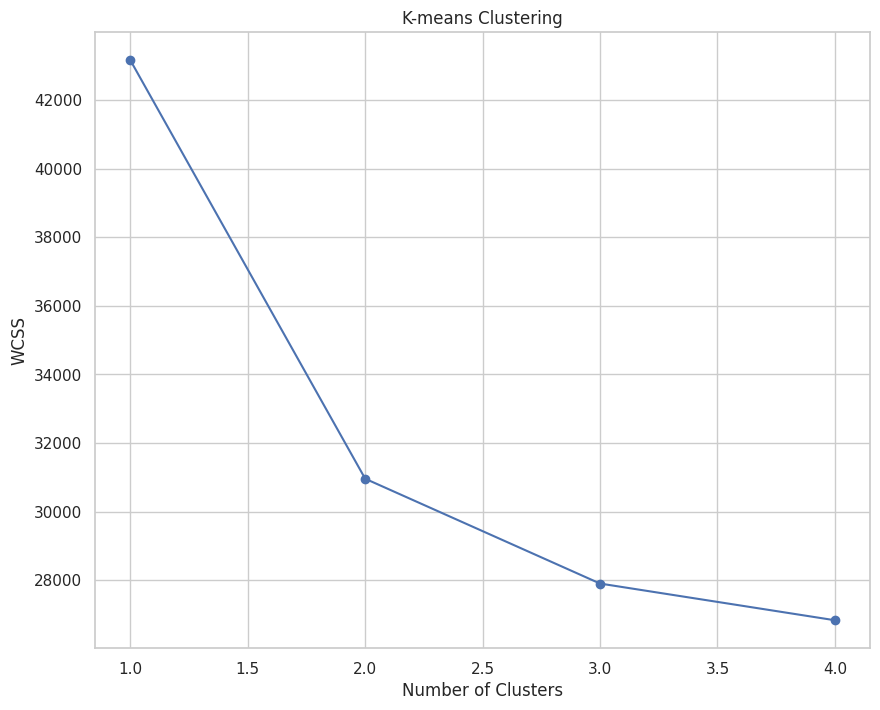

In [188]:
plt.figure(figsize = (10,8))
plt.plot(range(1,5), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [189]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(data_proc)
label = kmeans.predict(data_proc)
data_segment = data.copy()
data_segment['Segments'] = label

In [190]:
data_segment.groupby(['Segments']).mean()

,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Marital_Cerai,Marital_Duda,Marital_Janda,Marital_Lajang,Marital_Menikah,AgeGroup_25-35,AgeGroup_36-45,AgeGroup_46-55,AgeGroup_56-65,AgeGroup_>65
Segments,,,,,,,,,,,,,,,,,,,,,
0,3.919158e+07,0.685883,0.558019,48.819660,103199.556541,6658.536585,37413.155950,9816.703622,6779.009608,22562.453806,...,0.097561,0.002217,0.028086,0.218034,0.395418,0.021434,0.179601,0.368071,0.217295,0.212860
1,7.216193e+07,0.075536,0.427283,49.551297,610131.905299,56266.065389,364541.149944,79791.431793,58003.382187,76755.355130,...,0.112740,0.000000,0.043968,0.213078,0.370913,0.036077,0.135287,0.272830,0.239008,0.316798


In [191]:
data_segment['Labels'] = data_segment['Segments'].map({1:'well-off',
0:'fewer-opportunities'})

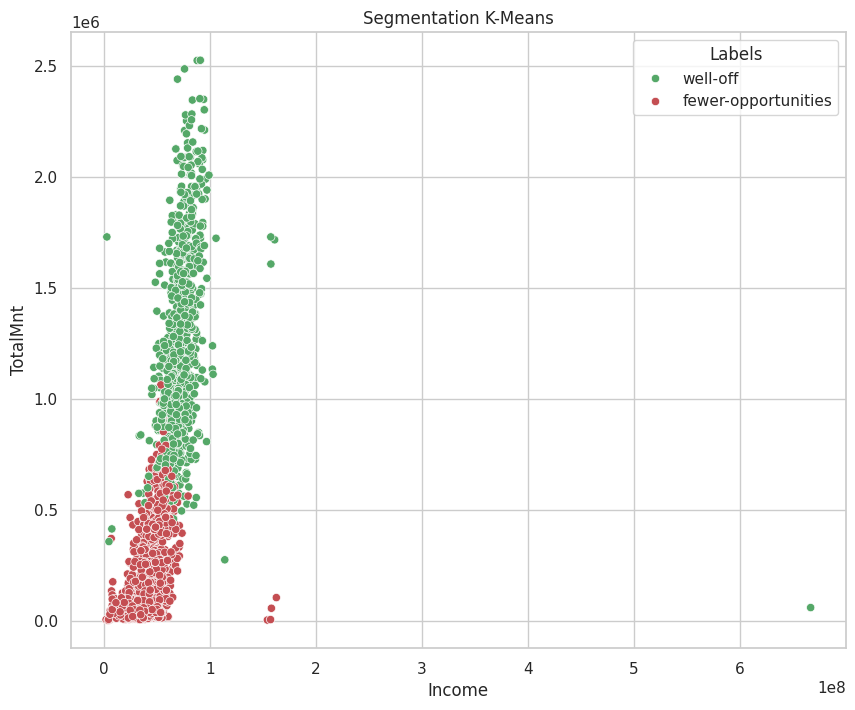

In [192]:
plt.figure(figsize = (10,8))
sns.scatterplot(x=data_segment['Income'], y=data_segment['TotalMnt'], hue=data_segment['Labels'], palette=['g', 'r'])
plt.title('Segmentation K-Means')
plt.show()

In [193]:
from sklearn.cluster import AgglomerativeClustering
agl =  AgglomerativeClustering(n_clusters=2)
agl.fit(data_proc)
label = agl.labels_
data_segment_3 = data.copy()
data_segment_3['cluster'] = label
data_segment_3.groupby(['cluster']).mean()

,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Marital_Cerai,Marital_Duda,Marital_Janda,Marital_Lajang,Marital_Menikah,AgeGroup_25-35,AgeGroup_36-45,AgeGroup_46-55,AgeGroup_56-65,AgeGroup_>65
cluster,,,,,,,,,,,,,,,,,,,,,
0,6.652336e+07,0.173554,0.533884,48.023967,524849.586777,44452.892562,289169.421488,63562.809917,45852.892562,68742.975207,...,0.111570,0.000826,0.045455,0.203306,0.385124,0.029752,0.123967,0.290909,0.249587,0.305785
1,3.547628e+07,0.762136,0.473786,50.384466,44415.533981,4979.611650,23371.844660,6937.864078,4989.320388,14980.582524,...,0.094175,0.001942,0.021359,0.231068,0.386408,0.024272,0.206796,0.376699,0.198058,0.193204


In [194]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

for i in range(2, 10):
    agl = AgglomerativeClustering(n_clusters=i)
    agl.fit(data_proc)
    label = agl.labels_
    score = silhouette_score(data_proc, label)
    print("Untuk k =", i, "silhouette score =", score)


Untuk k = 2 silhouette score = 0.21779480659748762
Untuk k = 3 silhouette score = 0.17959619695527448
Untuk k = 4 silhouette score = 0.17531630211672733
Untuk k = 5 silhouette score = 0.07662876669118064
Untuk k = 6 silhouette score = 0.07409705732210674
Untuk k = 7 silhouette score = 0.07412516575442071
Untuk k = 8 silhouette score = 0.06852009151574401
Untuk k = 9 silhouette score = 0.04912563734816982
